In [2]:
using MPSKit
using TensorKit
using KrylovKit
using TensorOperations
using MPSKitModels


using LoggingExtras
using MPSKit: updatetol, ∂∂AC,normalize!,add!, MPOHamiltonian,IterLog,loginit!,logiter!,logfinish!,logcancel!,fixedpoint, Algorithm, FiniteQP,LinearCombination,ProjectionOperator




### DMRG ADAPTATION to largest magnitude
@kwdef struct FiniteExcited_alt{A} <: Algorithm
    "optimization algorithm"
    gsalg::A = DMRG()
    "energy penalty for enforcing orthogonality with previous states"
    weight::Float64 = 1.0 ################THIS IS VARIABLE IN MY CODE -> because largest magn
end
function excitations_alt(H, alg::FiniteExcited_alt,
    states::Tuple{T,Vararg{T}},energies; #
    init=FiniteMPS([copy(first(states).AC[i])
                    for i in 1:length(first(states))]),
    num=1) where {T<:FiniteMPS}
num == 0 && return (scalartype(T)[], T[])
super_op = LinearCombination(tuple(H, ProjectionOperator.(states)...),
                energies)
envs = environments(init, super_op)
ne, _ = find_groundstate_alt(init, super_op, DMRG(maxiter = 500,tol=1e-6, eigalg =MPSKit.Defaults.alg_eigsolve(; ishermitian=false)), envs)
E = expectation_value(ne, H)
nstates = (states..., ne)
energies = (energies...,-E)
println(energies)
ens, excis = excitations_alt(H,alg, nstates,energies; init=init, num=num - 1) ## bit redudant, but don't want to screw up format

push!(ens, expectation_value(ne, H))
push!(excis, ne)

return ens, excis
end
function excitations_alt(H, alg::FiniteExcited_alt, ψ::FiniteMPS,energies; kwargs...) #,energies::Tuple{Float64}
return excitations_alt(H, alg, (ψ,),energies; kwargs...)
end



function calc_galerkin_alt(pos::Int, above::Union{InfiniteMPS,FiniteMPS,WindowMPS}, operator,
    below, envs)
AC´ = ∂∂AC(pos, above, operator, envs) * above.AC[pos]
normalize!(AC´)
out = add!(AC´, below.AL[pos] * below.AL[pos]' * AC´, -1)
return norm(out)
end

function find_groundstate_alt(ψ::FiniteMPS, H, alg, envs=environments(ψ, H))
    ϵs = map(pos -> calc_galerkin_alt(pos, ψ, H, ψ, envs), 1:length(ψ))
    ϵ = maximum(ϵs)
    log = IterLog("DMRG")

    LoggingExtras.withlevel(; alg.verbosity) do
        @infov 2 loginit!(log, ϵ, expectation_value(ψ, H, envs))
        for iter in 1:(alg.maxiter)
            alg_eigsolve = updatetol(alg.eigalg, iter, ϵ)

            zerovector!(ϵs)
            for pos in [1:(length(ψ) - 1); length(ψ):-1:2]
                h = ∂∂AC(pos, ψ, H, envs)
                _, vec = fixedpoint(h, ψ.AC[pos], :LM, alg_eigsolve)
                ϵs[pos] = max(ϵs[pos], calc_galerkin_alt(pos, ψ, H, ψ, envs))
                ψ.AC[pos] = vec
            end
            ϵ = maximum(ϵs)

            ψ, envs = alg.finalize(iter, ψ, H, envs)::Tuple{typeof(ψ),typeof(envs)}
            if ϵ <= 1e-5 ### I manually coded this because for some reason it would be turne dto 1e-10 for exications
                @infov 2 logfinish!(log, iter, ϵ, expectation_value(ψ, H, envs))
                break
            end
            if iter == alg.maxiter
                @warnv 1 logcancel!(log, iter, ϵ, expectation_value(ψ, H, envs))
            else
                @infov 3 logiter!(log, iter, ϵ, expectation_value(ψ, H, envs))
            end
        end
    end
    return ψ, envs, ϵ
end



find_groundstate_alt (generic function with 2 methods)

In [ ]:


function classical_Potts(q::Int64, β)
    V = ℂ^q
    A_potts = TensorMap(zeros,ComplexF64, V ⊗ V ← V ⊗ V)

    for i in 1:q
        for j in 1:q
            for k in 1:q
                for l in 1:q
                    E = -(Int(i == j) + Int(j == k) + Int(k == l) + Int(l == i))
                    A_potts[i, j, k, l] = exp(-β * E)
                end
            end
        end
    end
    return A_potts
end


function Plaquette_Potts(q::Int64, β, J□;JΔ=0.0)
    V = ℂ^q
    data = ComplexF64[Int(i==j)*Int(j==k) for i=1:q, j=1:q, k=1:q]
    δ3 = TensorMap(data, V ← V ⊗ V)
    U = isometry(fuse(V, V), V ⊗ V)
    A_potts = TensorMap(zeros,ComplexF64, V ⊗ V ← V ⊗ V)
    
    for i = 1:q
        for j = 1:q
            for k = 1:q
                for l = 1:q
                    # 0.5 factor for double counting the weight on the bond
                    E = -(Int(i == j) + Int(j == k) + Int(k == l) + Int(l == i))/2
                    E -= J□ * Int(i == j == k == l)
                    E -= JΔ * (Int(i==j==k)+Int(j==k==l)+Int(k==l==i)+Int(l==i==j))
                    A_potts[i, j, k, l] = exp(-β * E)
                end
            end
        end
    end
    @tensor Afin[-1 -2;-3 -4] := A_potts[1 2;3 4]*δ3[5;1 11]*conj(δ3[2; 6 7])*conj(δ3[10;3 8])*δ3[4;9 12]*U[-1;5 6]*U[-2;7 8]*conj(U[-3;9 10])*conj(U[-4;11 12]);
    #return Afin
    return A_potts
end

function eye(m)
    return Matrix{ComplexF64}(I,m,m)
end

function Potts_CCFT(L,Q,beta,lambda)
    L = 2
    H = zeros(ComplexF64,(Q^L,Q^L))
    sigma = zeros(ComplexF64,Q,Q)
    tau = zeros(ComplexF64,Q,Q)
    identity_e = zeros(ComplexF64,Q,Q)
    for i in 1:Q
        sigma[i, i] = cis(2*pi*(i-1)/Q)
        tau[i,mod1(i + 1, Q)] = 1
        identity_e[i,i]= 1
    end
    for i in 1:L-1
        H +=  kron(kron(eye(Q^(i-1)),lambda* sum(sum(kron(tau^k, identity_e) * kron(sigma', sigma)^p + kron(identity_e ,tau^k) * kron(sigma', sigma)^p + kron(sigma', sigma)^k * kron(tau^p, identity_e) +  kron(sigma', sigma)^k * kron(identity_e ,tau^p) for k in 1:1:Q-1) for p in 1:1:Q-1)), eye(Q^(L-i-1)))
         H += -0.5*kron(kron(eye(Q^(i-1)),(sum((tau^k) for k in 1:1:Q-1))),eye(Q^(L-i))) 
       H +=  -kron(kron(eye(Q^(i-1)), sum(kron(sigma'^k,sigma^k) for k in 1:Q-1)), eye(Q^(L-i-1)))

    end
    H += -0.5*kron(eye(Q^(L-1)),sum((tau^k) for k in 1:1:Q-1))
    
    Transfer_Matrix = exp(-beta*H )   #### a little bit wrong since you work with beta/n -> in fractions this is okay but the first two plots are not representative
    V= ℂ^Q
    A_CCFT = TensorMap(Transfer_Matrix, V ⊗ V ← V ⊗ V)   

    
    return A_CCFT
end


function_p

Potts_CCFT (generic function with 1 method)

In [16]:
D=150
J=1
h=1
Q=5
using JLD2
N = 5
test_values = zeros(ComplexF64,(2*N-1)^2)

l = length(test_values)
function Potts_βc(q)
    return log(1+sqrt(q))
end

distx = 0.05## distance from centre in real

disty = 0.05# distance from centre in imaginary

cent_im =  0.0601im

cent_r = 0.0780
include("Potts-Operators & Hamiltonian.jl")
## snake like structure of test_values will allow for faster convergence when recycling ψ (because you don't jump the entire distx after the loop)
for i in 1:1:(2*N-1)
    if div(i,2) == 1
        for j in 1:1:(2*N-1)
            if i <N+1
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i])  .+cent_r+ 1im*LinRange(-disty,0.00,N)[j] .+cent_im
                else 
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i])  .+cent_r + 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N] .+cent_im
                end
            else
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N]) .+cent_r  + 1im*LinRange(-disty,0.00,N)[j]  .+cent_im
                else
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N])  .+cent_r+ 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N].+cent_im
                end
            end 
        end
    else
        for j in (2*N-1):-1:1
            if i <N+1
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i]) .+cent_r+ 1im*LinRange(-disty,0.00,N)[j] .+cent_im
                else 
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i])  .+cent_r + 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N] .+cent_im
                end
            else
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N]) .+cent_r + 1im*LinRange(-disty,0.00,N)[j] .+cent_im
                else
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N])   .+cent_r + 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N] .+cent_im
                end
            end 
        end
    end
end

for L in [4]
    l = length(test_values)
    Results = zeros(ComplexF64,(2,l))

    ψ = FiniteMPS(L,ℂ^(Q), ℂ^D)
    ψ2 = FiniteMPS(L,ℂ^(Q), ℂ^D)
    #ψ3 = FiniteMPS(L,ℂ^(Q), ℂ^D) if you want this need to change how init works
    for (i,lambda) in enumerate(test_values)
        # for (j,JΔ) in enumerate(test_values_1)
        # println(i/l)
        plaq = @mpoham  Potts_CCFT(Q,Potts_βc(Q),lambda){vertices(FiniteChain(L))[end],vertices(FiniteChain(L))[1]} + sum(Potts_CCFT(Q,Potts_βc(Q),lambda){i,i+1} for i in vertices(FiniteChain(L))[1:end-1]) 
        (ψ, envir , delta) = find_groundstate_alt(ψ, plaq, DMRG(maxiter = 500,tol=1e-5, eigalg =MPSKit.Defaults.alg_eigsolve(; ishermitian=false)))
        E = expectation_value(ψ, plaq)
        En, state  = excitations_alt(plaq, FiniteExcited_alt(gsalg = DMRG(eigalg =MPSKit.Defaults.alg_eigsolve(maxiter = 500,tol=1e-5,ishermitian=false))), (ψ,),(1.0,-E),init = ψ2,num=1) 
        ψ2 = state[1]

  
        println(E)
        println(En)
        
        Results[1,i] = E
        Results[2,i] = En[1]
    end

    save_object("Leading boundary CCFT DMRG $L,D$D",Results)
end


┌ Info: DMRG init:	obj = +1.018932106024e+03 -8.803938129210e+01im	err = 2.5753e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.221281891296e+03 -1.058511389887e+02im	err = 6.7608686903e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = -2.691486068178e+03 +2.333598332883e+02im	err = 8.1249e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -1221.2818912962257 + 105.85113898867165im, -880.4875442028051 + 64.94439750249492im)
1221.2818912962257 - 105.85113898867165im
ComplexF64[880.4875442028051 - 64.94439750249492im]


┌ Info: DMRG conv 1:	obj = +8.804875442028e+02 -6.494439750249e+01im	err = 6.4244558316e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.097540117044e+03 -9.481009833687e+01im	err = 5.4151e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, 

┌ Info: DMRG conv 1:	obj = +1.097599295677e+03 -9.471119707488e+01im	err = 7.7105091495e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +8.044027430593e+02 -5.841194873151e+01im	err = 1.1106e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.047981353220e+02 -5.775440632405e+01im	err = 8.6739404019e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


-1097.5992956771 + 94.71119707487517im, -804.7981353220359 + 57.75440632405284im)
1097.5992956771 - 94.71119707487517im
ComplexF64[804.7981353220359 - 57.75440632405284im]


┌ Info: DMRG init:	obj = +9.869139941654e+02 -8.477027472208e+01im	err = 6.2227e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.869849404265e+02 -8.464978185043e+01im	err = 1.0670702061e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.371507227431e+02 -5.192004930347e+01im	err = 1.2308e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -986.9849404264759 + 84.64978185043086im, -737.606660262246 + 51.15922043638838im)
986.9849404264759 - 84.64978185043086im

┌ Info: DMRG conv 1:	obj = +7.376066602622e+02 -5.115922043639e+01im	err = 6.1677405456e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77



ComplexF64[737.606660262246 - 51.15922043638838im]


┌ Info: DMRG init:	obj = +8.881026227496e+02 -7.568321052206e+01im	err = 7.2447e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.881895331858e+02 -7.553244562155e+01im	err = 1.3720941542e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.777039516902e+02 -4.595664400815e+01im	err = 1.3646e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -888.1895331857875 + 75.53244562154852im, -678.2314076460292 + 45.07493691578589im)
888.1895331857875 - 75.53244562154852im
ComplexF64[678.2314076460292 - 45.07493691578589im]


┌ Info: DMRG conv 1:	obj = +6.782314076460e+02 -4.507493691579e+01im	err = 7.9580891088e-09	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +8.000165354780e+02 -6.742366357316e+01im	err = 8.5756e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.001258618596e+02 -6.722862888269e+01im	err = 1.5816794137e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0

┌ Info: DMRG init:	obj = +6.254798416356e+02 -4.044496196416e+01im	err = 1.5117e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.260903780658e+02 -3.942459866542e+01im	err = 9.2790449638e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -800.1258618596181 + 67.22862888269455im, -626.0903780657942 + 39.42459866542424im)
800.1258618596181 - 67.22862888269455im
ComplexF64[626.0903780657942 - 39.42459866542424im]


┌ Info: DMRG init:	obj = +7.217247512938e+02 -5.986816120263e+01im	err = 1.0363e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.218668343595e+02 -5.960530159734e+01im	err = 1.8234925624e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +5.799876637392e+02 -3.531403312482e+01im	err = 1.6705e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.806922803504e+02 -3.413865398341e+01im	err = 1.2718970025e-08	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -721.8668343594674 + 59.60530159733847im, -580.6922803503971 + 34.138653983414365im)
721.8668343594674 - 59.60530159733847im
ComplexF64[580.6922803503971 - 34.138653983414365im]


┌ Info: DMRG init:	obj = +6.524607501672e+02 -5.288840825724e+01im	err = 1.2835e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.526528596603e+02 -5.251646683861e+01im	err = 4.3055936291e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.408192406746e+02 -3.049867953285e+01im	err = 1.8371e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.416267846471e+02 -2.915400854216e+01im	err = 1.8149501048e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -652.652859660323 + 52.51646683860967im, -541.6267846471345 + 29.154008542159733im)
652.652859660323 - 52.51646683860967im
ComplexF64[541.6267846471345 - 29.154008542159733im]


┌ Info: DMRG init:	obj = +5.916429968728e+02 -4.634033185363e+01im	err = 1.6338e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.919151136994e+02 -4.578428307179e+01im	err = 1.9296994526e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.076409102667e+02 -2.593756330188e+01im	err = 2.0066e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -591.9151136994461 + 45.78428307178622im, -508.55694856904086 + 24.406985179687343im)
591.9151136994461 - 45.78428307178622im
ComplexF64[508.55694856904086 - 24.406985179687343im]


┌ Info: DMRG conv 1:	obj = +5.085569485690e+02 -2.440698517969e+01im	err = 2.2110423644e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.389218557316e+02 -4.004436968169e+01im	err = 2.1387e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.393278144413e+02 -3.916255634336e+01im	err = 1.3375435787e-08	time = 0.10 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.801957825561e+02 -2.156394903422e+01im	err = 2.1754e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -539.327814441291 + 39.16255634335677im, -481.22431297370736 + 19.808202740601295im)
539.327814441291 - 39.16255634335677im
ComplexF64[481.22431297370736 - 19.808202740601295im]


┌ Info: DMRG conv 1:	obj = +4.812243129737e+02 -1.980820274060e+01im	err = 3.6165877035e-08	time = 0.33 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.175978995547e+03 -2.241712300660e+02im	err = 1.1188e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.202351925086e+03 -2.356655803248e+02im	err = 1.6528203240e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0,

┌ Info: DMRG init:	obj = +7.991686900763e+02 -1.110006111343e+02im	err = 1.5368e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.683520372726e+02 -1.446535936054e+02im	err = 8.7252440295e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 -1202.3519250862266 + 235.66558032476303im, -868.3520372725579 + 144.65359360540856im)
1202.3519250862266 - 235.66558032476303im
ComplexF64[868.3520372725579 - 144.65359360540856im]


┌ Info: DMRG init:	obj = +1.080472096156e+03 -2.110934573152e+02im	err = 5.3798e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -1080.5244900944406 + 210.87719696080907im, -793.6946586349039 + 128.6534355049676

┌ Info: DMRG conv 1:	obj = +1.080524490094e+03 -2.108771969608e+02im	err = 8.2804509514e-10	time = 0.09 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.933381284360e+02 -1.301052914577e+02im	err = 1.1021e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.936946586349e+02 -1.286534355050e+02im	err = 1.2135729756e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


im)
1080.5244900944406 - 210.87719696080907im
ComplexF64[793.6946586349039 - 128.6534355049676im]


┌ Info: DMRG init:	obj = +9.714839384311e+02 -1.887561908295e+02im	err = 6.1766e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.715432689161e+02 -1.884940161831e+02im	err = 1.2301099013e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.269875463735e+02 -1.156588927878e+02im	err = 1.2223e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -971.5432689161139 + 188.4940161831084im, -727.3939887460579 + 113.97779366825908im)
971.5432689161139 - 188.4940161831084im
ComplexF64[727.3939887460579 - 113.97779366825908im]


┌ Info: DMRG conv 1:	obj = +7.273939887461e+02 -1.139777936683e+02im	err = 1.4288133368e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +8.741025949321e+02 -1.685449623946e+02im	err = 7.1826e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -874.1695939771545 + 168.21921609854968im, -668.7790096749985 + 100.43864928662619im)
874.1695939771545 - 168.21921609854968im
ComplexF64[668.7790096749985 - 100.43864928662619im]


┌ Info: DMRG conv 1:	obj = +8.741695939772e+02 -1.682192160985e+02im	err = 1.8023292430e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.683113167203e+02 -1.023892876882e+02im	err = 1.3565e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.687790096750e+02 -1.004386492866e+02im	err = 1.7490243409e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.872444739136e+02 -1.501838459653e+02im	err = 8.4891e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.873191157534e+02 -1.497665419409e+02im	err = 2.6613074482e-09	time = 0.01 

(1.0, -787.3191157534407 + 149.76654194089073im, -617.2794155436571 + 87.86312826718613im)
787.3191157534407 - 149.76654194089073im
ComplexF64[617.2794155436571 - 87.86312826718613im]


┌ Info: DMRG init:	obj = +7.099753861881e+02 -1.334030470984e+02im	err = 1.0238e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.100556725699e+02 -1.328479215903e+02im	err = 4.4257896264e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.717845893050e+02 -7.870419997153e+01im	err = 1.6649e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.724167944249e+02 -7.609583960644e+01im	err = 2.3959788763e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -710.0556725698565 + 132.84792159028336im, -572.4167944248975 + 76.09583960643539im)
710.0556725698565 - 132.84792159028336im
ComplexF64[572.4167944248975 - 76.09583960643539im]


┌ Info: DMRG init:	obj = +6.415110945779e+02 -1.179262270342e+02im	err = 1.2649e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.415903857783e+02 -1.171537233608e+02im	err = 1.0601232999e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0

┌ Info: DMRG init:	obj = +5.330585028064e+02 -6.798301304527e+01im	err = 1.8341e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.337914572425e+02 -6.500075034758e+01im	err = 2.5387113506e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -641.5903857782918 + 117.153723360828im, -533.7914572425194 + 65.00075034758439im)
641.5903857782918 - 117.153723360828im
ComplexF64[533.7914572425194 - 65.00075034758439im]


┌ Info: DMRG init:	obj = +5.812270918968e+02 -1.034501524854e+02im	err = 1.6053e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.812882132144e+02 -1.023184578435e+02im	err = 6.8358695853e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -581.288213214406

┌ Info: DMRG init:	obj = +5.002318782577e+02 -5.782782834149e+01im	err = 2.0068e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.010616573434e+02 -5.445543663628e+01im	err = 3.0200637478e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 102.31845784348961im, -501.0616573434194 + 54.455436636278066im)
581.288213214406 - 102.31845784348961im
ComplexF64[501.0616573434194 - 54.455436636278066im]


┌ Info: DMRG init:	obj = +5.286837403976e+02 -8.960930343365e+01im	err = 2.0937e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.286856184678e+02 -8.785740974453e+01im	err = 2.8295865328e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +4.730304353136e+02 -4.810831876563e+01im	err = 2.1789e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.739124355670e+02 -4.432056388986e+01im	err = 7.6475602720e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -528.6856184678185 + 87.85740974452632im, -473.91243556697367 + 44.320563889857205im)
528.6856184678185 - 87.85740974452632im
ComplexF64[473.91243556697367 - 44.320563889857205im]


┌ Info: DMRG init:	obj = +1.145020080321e+03 -3.460415273805e+02im	err = 1.0858e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.169202214150e+03 -3.627631341015e+02im	err = 1.5506456413e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.822088472419e+02 -1.715954091128e+02im	err = 1.5328e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -1169.2022141503166 + 362.76313410147895im, -847.1000641954643 + 222.83837994838385im)
1169.2022141503166 - 362.76313410147895im
ComplexF64[847.1000641954643 - 222.83837994838385im]


┌ Info: DMRG conv 1:	obj = +8.471000641955e+02 -2.228383799484e+02im	err = 2.1914367145e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.050588697398e+03 -3.249641920205e+02im	err = 5.3193e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.050630783702e+03 -3.246412453622e+02im	err = 8.9775916148e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -1050.630783701962 + 324.64124536223716im,

┌ Info: DMRG init:	obj = +7.739648602221e+02 -2.004316392630e+02im	err = 1.0880e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.742524514136e+02 -1.982302986886e+02im	err = 3.3000081364e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 -774.2524514135508 + 198.23029868860152im)
1050.630783701962 - 324.64124536223716im
ComplexF64[774.2524514135508 - 198.23029868860152im]


┌ Info: DMRG init:	obj = +9.444775933549e+02 -2.906201388558e+02im	err = 6.0985e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.445196633157e+02 -2.902317267326e+02im	err = 1.4296707639e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -944.5196633157427 + 290.23172673260285im, -709.5124510635055 + 175.662341430229im)

┌ Info: DMRG init:	obj = +7.091950725893e+02 -1.782141042169e+02im	err = 1.2076e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.095124510635e+02 -1.756623414302e+02im	err = 4.9041628780e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77



944.5196633157427 - 290.23172673260285im
ComplexF64[709.5124510635055 - 175.662341430229im]


┌ Info: DMRG init:	obj = +8.496128692282e+02 -2.595608828604e+02im	err = 7.0786e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.496510155852e+02 -2.590837461112e+02im	err = 2.3353361831e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -849.6510155852245 + 259.0837461112487im, -652.2266593989492 + 154.8416414394195im)
849.6510155852245 - 259.0837461112487im
ComplexF64[652.2266593989492 - 154.8416414394195im]


┌ Info: DMRG init:	obj = +6.518682636964e+02 -1.578091384812e+02im	err = 1.3417e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.522266593989e+02 -1.548416414394e+02im	err = 6.3570387649e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.649240011025e+02 -2.313687241489e+02im	err = 8.3459e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.649496820140e+02 -2.307671791714e+02im	err = 4.0029165658e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.014280140040e+02 -1.389482286442e+02im	err = 1.4907e-02
└ @ Main c:\Users\vi

(1.0, -764.9496820139568 + 230.7671791713723im, -601.8448165944402 + 135.49681513065337im)
764.9496820139568 - 230.7671791713723im
ComplexF64[601.8448165944402 - 135.49681513065337im]


┌ Info: DMRG conv 1:	obj = +6.018448165944e+02 -1.354968151307e+02im	err = 7.3704438569e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.894764092947e+02 -2.056404952511e+02im	err = 1.0034e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -689.471693241721 + 204.85755034541228im

┌ Info: DMRG conv 1:	obj = +6.894716932417e+02 -2.048575503454e+02im	err = 7.5734115464e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.574143246378e+02 -1.213802035237e+02im	err = 1.6535e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.579139700457e+02 -1.173837034165e+02im	err = 8.5983209219e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -557.9139700456518 + 117.38370341654016im)
689.471693241721 - 204.85755034541228im
ComplexF64[557.9139700456518 - 117.38370341654016im]


┌ Info: DMRG init:	obj = +6.224649378864e+02 -1.819725651055e+02im	err = 1.2350e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.223929353598e+02 -1.809136627615e+02im	err = 1.7182617862e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.194558964548e+02 -1.048749948014e+02im	err = 1.8272e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -622.3929353597799 + 180.91366276150563im, -520.0654224195525 + 100.29639499178619im)
622.3929353597799 - 180.91366276150563im
ComplexF64[520.0654224195525 - 100.29639499178619im]


┌ Info: DMRG conv 1:	obj = +5.200654224196e+02 -1.002963949918e+02im	err = 1.1710168864e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.632099257896e+02 -1.599384366383e+02im	err = 1.5600e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(

┌ Info: DMRG conv 1:	obj = +5.629953510606e+02 -1.584412480225e+02im	err = 1.1363643015e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.872533349447e+02 -8.923069828024e+01im	err = 2.0066e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.879832789115e+02 -8.407890002951e+01im	err = 1.5251127400e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -562.9953510605575 + 158.4412480225126im, -487.98327891147534 + 84.07890002950798im)
562.9953510605575 - 158.4412480225126im
ComplexF64[487.98327891147534 - 84.07890002950798im]


┌ Info: DMRG init:	obj = +5.111554729686e+02 -1.390522586119e+02im	err = 2.0231e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.106447280227e+02 -1.368297834130e+02im	err = 9.3363232060e-16	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.605434748666e+02 -7.427834697719e+01im	err = 2.1868e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -510.64472802269285 + 136.8297834129968im, -461.33985812568847 + 68.62121170447463im)
510.64472802269285 - 136.8297834129968im
ComplexF64[461.33985812568847 - 68.62121170447463im]


┌ Info: DMRG conv 1:	obj = +4.613398581257e+02 -6.862121170447e+01im	err = 1.7044274711e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.100932985312e+03 -4.652749231766e+02im	err = 1.0332e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.122247165726e+03 -4.856724194653e+02im	err = 1.4547002091e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.567866309734e+02 -2.307544531238e+02im	err = 1.5301e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -1122.2471657257709 + 485.6724194652815im, -816.9982636061997 + 298.6734584818356im)
1122.2471657257709 - 485.6724194652815im
ComplexF64[816.9982636061997 - 298.6734584818356im]


┌ Info: DMRG conv 1:	obj = +8.169982636062e+02 -2.986734584818e+02im	err = 3.0994351870e-08	time = 0.33 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.008272310888e+03 -4.351135226704e+02im	err = 5.2363e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.008302629663e+03 -4.346983026067e+02im	err = 9.4174926903e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.465317430623e+02 -2.686512773739e+02im	err = 1.0701e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -1008.3026296634018 + 434.6983026066988im, -746.7205308646476 + 265.77035539067185im)
1008.3026296634018 - 434.6983026066988im
ComplexF64[746.7205308646476 - 265.77035539067185im]


┌ Info: DMRG conv 1:	obj = +7.467205308646e+02 -2.657703553907e+02im	err = 3.6862196941e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +9.062541757149e+02 -3.892059903882e+02im	err = 5.9928e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.062773253901e+02 -3.887114482246e+02im	err = 1.5654964722e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -906.2773253900601 + 388.71144822463714im, -684.1939171361792 + 235.60308120298495im)
906.2773253900601 - 388.71144822463714im
ComplexF64[684.1939171361792 - 235.60308120298495im]


┌ Info: DMRG init:	obj = +6.840070828449e+02 -2.389466030510e+02im	err = 1.1886e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.841939171362e+02 -2.356030812030e+02im	err = 5.6506987324e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +8.149789495607e+02 -3.477170417762e+02im	err = 6.9405e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.149869772912e+02 -3.471179926947e+02im	err = 2.7080104633e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.285932664702e+02 -2.116729369128e+02im	err = 1.3224e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.287867491557e+02 -2.077731286827e+02im	err = 7.9616769975e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -814.9869772912431 + 347.1179926946551im, -628.7867491557278 + 207.77312868265213im)
814.9869772912431 - 347.1179926946551im
ComplexF64[628.7867491557278 - 207.77312868265213im]


┌ Info: DMRG init:	obj = +7.333996881414e+02 -3.100987166995e+02im	err = 8.1600e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.333769330472e+02 -3.093584517719e+02im	err = 4.9415263893e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0,

┌ Info: DMRG init:	obj = +5.797532498943e+02 -1.864646118663e+02im	err = 1.4723e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.799737481743e+02 -1.819050805526e+02im	err = 1.0296407331e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 -733.3769330471889 + 309.3584517718703im, -579.9737481743391 + 181.90508055262373im)
733.3769330471889 - 309.3584517718703im
ComplexF64[579.9737481743391 - 181.90508055262373im]


┌ Info: DMRG init:	obj = +6.605906339861e+02 -2.758301355349e+02im	err = 9.7764e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.605063606550e+02 -2.748932820523e+02im	err = 9.6996580373e-09	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +5.370511766475e+02 -1.629737402194e+02im	err = 1.6382e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.373385914599e+02 -1.576544447230e+02im	err = 1.3399625494e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -660.5063606550113 + 274.89328205227656im, -537.3385914599338 + 157.65444472295184im)
660.5063606550113 - 274.89328205227656im
ComplexF64[537.3385914599338 - 157.65444472295184im]


┌ Info: DMRG init:	obj = +5.957347990252e+02 -2.444038723380e+02im	err = 1.1980e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.955288155557e+02 -2.431840869816e+02im	err = 3.1985028808e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.001529244613e+02 -1.408754538509e+02im	err = 1.8182e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -595.5288155556999 + 243.1840869815662im, -500.5722878439354 + 134.7310889299968im)
595.5288155556999 - 243.1840869815662im
ComplexF64[500.5722878439354 - 134.7310889299968im]


┌ Info: DMRG conv 1:	obj = +5.005722878439e+02 -1.347310889300e+02im	err = 1.9303485397e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.381089985567e+02 -2.153083728034e+02im	err = 1.5054e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.376634556990e+02 -2.136671144524e+02im	err = 1.1850863199e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.688184493189e+02 -1.198860258988e+02im	err = 2.0078e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -537.6634556989903 + 213.667114452357im, -469.4474674599754 + 112.94443804903794im)
537.6634556989903 - 213.667114452357im
ComplexF64[469.4474674599754 - 112.94443804903794im]


┌ Info: DMRG conv 1:	obj = +4.694474674600e+02 -1.129444380490e+02im	err = 3.1499873704e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.870614388425e+02 -1.880033478480e+02im	err = 1.9401e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -486.14488875119986 + 185.7135601831571

┌ Info: DMRG conv 1:	obj = +4.861448887512e+02 -1.857135601832e+02im	err = 1.0693529896e-15	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.428642671262e+02 -9.979937694603e+01im	err = 2.2011e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.437316737823e+02 -9.225598126501e+01im	err = 4.5204410909e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


im, -443.7316737823075 + 92.2559812650107im)
486.14488875119986 - 185.7135601831571im
ComplexF64[443.7316737823075 - 92.2559812650107im]


┌ Info: DMRG init:	obj = +1.043934858795e+03 -5.804927430945e+02im	err = 9.6858e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(

┌ Info: DMRG conv 1:	obj = +1.062070649918e+03 -6.029636793500e+02im	err = 1.3413290364e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.225706619847e+02 -2.871302761967e+02im	err = 1.5314e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.784257045671e+02 -3.713552973931e+02im	err = 4.4779996377e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -1062.070649917684 + 602.9636793499661im, -778.4257045670847 + 371.355297393146im)
1062.070649917684 - 602.9636793499661im
ComplexF64[778.4257045670847 - 371.355297393146im]


┌ Info: DMRG init:	obj = +9.540604858966e+02 -5.402671961409e+02im	err = 5.1337e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.540793287801e+02 -5.397758742513e+02im	err = 9.3534832197e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.113927813536e+02 -3.340442459460e+02im	err = 1.0471e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.114550702361e+02 -3.305784013573e+02im	err = 4.2704102790e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -954.0793287801351 + 539.7758742513391im, -711.4550702360995 + 330.57840135727065im)
954.0793287801351 - 539.7758742513391im
ComplexF64[711.4550702360995 - 330.57840135727065im]


┌ Info: DMRG init:	obj = +8.573157396176e+02 -4.833829036162e+02im	err = 5.8649e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.573216507856e+02 -4.828035616019e+02im	err = 1.5700342279e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.517587504840e+02 -2.972351603116e+02im	err = 1.1640e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.517735868259e+02 -2.932101367972e+02im	err = 6.7155474836e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -857.3216507855535 + 482.80356160188666im, -651.7735868259043 + 293.2101367972451im)
857.3216507855535 - 482.80356160188666im
ComplexF64[651.7735868259043 - 293.2101367972451im]


┌ Info: DMRG init:	obj = +7.706787129269e+02 -4.320135210146e+02im	err = 6.7773e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0

┌ Info: DMRG conv 1:	obj = +7.706616932617e+02 -4.313217627563e+02im	err = 2.7420215874e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.988036981760e+02 -2.634561256424e+02im	err = 1.2968e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.987708831079e+02 -2.587474412001e+02im	err = 1.0250811151e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -770.6616932617361 + 431.321762756345im, -598.7708831079266 + 258.74744120013685im)
770.6616932617361 - 431.321762756345im
ComplexF64[598.7708831079266 - 258.74744120013685im]


┌ Info: DMRG init:	obj = +6.931393531011e+02 -3.854930152892e+02im	err = 7.9471e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.930806759502e+02 -3.846557484698e+02im	err = 5.0555378763e-09	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.520080693075e+02 -2.322455095925e+02im	err = 1.4471e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.519432734483e+02 -2.267043104287e+02im	err = 1.4931363357e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -693.0806759501799 + 384.6557484697819im, -551.9432734482862 + 226.70431042869842im)
693.0806759501799 - 384.6557484697819im
ComplexF64[551.9432734482862 - 226.70431042869842im]


┌ Info: DMRG init:	obj = +6.237952302369e+02 -3.431976210562e+02im	err = 9.4913e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.236594654643e+02 -3.421691628050e+02im	err = 1.0010223198e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.109559435361e+02 -2.031530248192e+02im	err = 1.6159e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -623.6594654642528 + 342.16916280498856im, -510.9096725308092 + 196.61400888194336im)
623.6594654642528 - 342.16916280498856im
ComplexF64[510.9096725308092 - 196.61400888194336im]


┌ Info: DMRG conv 1:	obj = +5.109096725308e+02 -1.966140088819e+02im	err = 2.2366144804e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.618364113541e+02 -3.045357293918e+02im	err = 1.1588e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.615562680695e+02 -3.032520360465e+02im	err = 2.6261486788e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -561.5562680694823 + 303.25203604645105im, -475.4395667587036 + 168.05572038839108im)
561.5562680694823 - 303.25203604645105im
ComplexF64[475.4395667587036 - 168.05572038839108im]


┌ Info: DMRG init:	obj = +4.753502548086e+02 -1.757394559448e+02im	err = 1.8029e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.754395667587e+02 -1.680557203884e+02im	err = 1.0983642528e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +5.065258603028e+02 -2.689386803504e+02im	err = 1.4501e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.059736685530e+02 -2.673093862122e+02im	err = 9.0890948032e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.450353331146e+02 -1.495974914621e+02im	err = 2.0056e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.454749217172e+02 -1.407410243159e+02im	err = 1.9158043936e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -505.9736685530397 + 267.3093862122497im, -445.47492171721433 + 140.7410243158814im)
505.9736685530397 - 267.3093862122497im
ComplexF64[445.47492171721433 - 140.7410243158814im]


┌ Info: DMRG init:	obj = +4.571695930107e+02 -2.358537782505e+02im	err = 1.8594e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.561041152283e+02 -2.337536236467e+02im	err = 2.7742292775e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.200021637930e+02 -1.244271343812e+02im	err = 2.2183e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -456.1041152282597 + 233.7536236467357im, -421.05634378937805 + 114.68807618873066im)
456.1041152282597 - 233.7536236467357im
ComplexF64[421.05634378937805 - 114.68807618873066im]


┌ Info: DMRG conv 1:	obj = +4.210563437894e+02 -1.146880761887e+02im	err = 3.6856938542e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +9.744343567021e+02 -6.899674088215e+02im	err = 9.0106e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.894163646918e+02 -7.132647482400e+02im	err = 1.2055023323e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.794873131226e+02 -3.392705137043e+02im	err = 1.5348e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.318694886531e+02 -4.401075960957e+02im	err = 6.8267207604e-08	time = 0.05 

(1.0, -989.4163646918385 + 713.2647482400249im, -731.8694886530634 + 440.1075960957336im)
989.4163646918385 - 713.2647482400249im
ComplexF64[731.8694886530634 - 440.1075960957336im]


┌ Info: DMRG init:	obj = +8.886360991626e+02 -6.391993642401e+02im	err = 5.0147e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -888.6445447038791 + 638.6482887153259im, -668.917119426512 + 391.981615402375im)


┌ Info: DMRG conv 1:	obj = +8.886445447039e+02 -6.386482887153e+02im	err = 8.7725757733e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.690030880210e+02 -3.959150129527e+02im	err = 1.0187e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.689171194265e+02 -3.919816154024e+02im	err = 5.0660907163e-09	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


888.6445447038791 - 638.6482887153259im
ComplexF64[668.917119426512 - 391.981615402375im]


┌ Info: DMRG init:	obj = +7.982960413055e+02 -5.720576896256e+02im	err = 5.7196e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.982878184247e+02 -5.714135394414e+02im	err = 1.4406788200e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -798.2878184246734 + 571.4135394414352im, -612.6919741729345 + 347.914282482264im)
798.2878184246734 - 571.4135394414352im
ComplexF64[612.6919741729345 - 347.914282482264im]


┌ Info: DMRG init:	obj = +6.128849266630e+02 -3.524786230695e+02im	err = 1.1331e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.126919741729e+02 -3.479142824823e+02im	err = 8.0270008096e-09	time = 0.30 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.173086487614e+02 -5.114759943655e+02im	err = 6.5975e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.172741981580e+02 -5.107161495214e+02im	err = 2.4303834402e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.629189109758e+02 -3.126527771586e+02im	err = 1.2638e-02
└ @ Main c:\Users\vi

(1.0, -717.2741981579865 + 510.7161495214213im, -562.5999611568461 + 307.30482790510155im)
717.2741981579865 - 510.7161495214213im
ComplexF64[562.5999611568461 - 307.30482790510155im]


┌ Info: DMRG init:	obj = +6.447153426292e+02 -4.566817738983e+02im	err = 7.7213e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -644.6377750458961 + 455.7780073464232im, -518.1437263733269 + 269.5568068830373im)
644.6377750458961 - 

┌ Info: DMRG conv 1:	obj = +6.446377750459e+02 -4.557780073464e+02im	err = 4.3384182910e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.185958150368e+02 -2.758867090709e+02im	err = 1.4131e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.181437263733e+02 -2.695568068830e+02im	err = 2.1784196218e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


455.7780073464232im
ComplexF64[518.1437263733269 - 269.5568068830373im]


┌ Info: DMRG init:	obj = +5.796538461669e+02 -4.069602457728e+02im	err = 9.2035e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.795025071572e+02 -4.058780093453e+02im	err = 8.5894601484e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.795022096535e+02 -2.416288053175e+02im	err = 1.5833e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -579.502507157212 + 405.8780093453171im, -478.9479406136148 + 234.06052993074462im)
579.502507157212 - 405.8780093453171im
ComplexF64[478.9479406136148 - 234.06052993074462im]


┌ Info: DMRG conv 1:	obj = +4.789479406136e+02 -2.340605299307e+02im	err = 1.1012511307e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.213440440974e+02 -3.616477707552e+02im	err = 1.1216e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0

┌ Info: DMRG conv 1:	obj = +5.210625202801e+02 -3.603464158572e+02im	err = 1.9516992774e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.453478366700e+02 -2.093079843356e+02im	err = 1.7766e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.448258229830e+02 -2.001870497526e+02im	err = 2.4168381224e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -521.0625202800637 + 360.3464158572273im, -444.8258229829577 + 200.1870497526391im)
521.0625202800637 - 360.3464158572273im
ComplexF64[444.8258229829577 - 200.1870497526391im]


┌ Info: DMRG init:	obj = +4.690706403565e+02 -3.201304085919e+02im	err = 1.4009e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(

┌ Info: DMRG conv 1:	obj = +4.685551252870e+02 -3.185661440377e+02im	err = 6.2042487434e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.160324190943e+02 -1.783240032449e+02im	err = 1.9942e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.159265417776e+02 -1.673609710857e+02im	err = 1.3918810475e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -468.555125286955 + 318.5661440376839im, -415.92654177762915 + 167.36097108567736im)
468.555125286955 - 318.5661440376839im
ComplexF64[415.92654177762915 - 167.36097108567736im]


┌ Info: DMRG init:	obj = +4.221587824057e+02 -2.818517623148e+02im	err = 1.7930e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.212212093789e+02 -2.799881300329e+02im	err = 1.7073324462e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.917825063841e+02 -1.481089455373e+02im	err = 2.2347e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -421.2212093788612 + 279.98813003286796im, -392.89292517358894 + 135.45016188877742im)
421.2212093788612 - 279.98813003286796im
ComplexF64[392.89292517358894 - 135.45016188877742im]


┌ Info: DMRG conv 1:	obj = +3.928929251736e+02 -1.354501618888e+02im	err = 3.7250247319e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +8.930879916487e+02 -7.918801572703e+02im	err = 8.3832e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +9.051765656483e+02 -8.152772580864e+02im	err = 1.0639555550e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.274784026732e+02 -3.859141456286e+02im	err = 1.5380e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -905.1765656483431 + 815.277258086416im

┌ Info: DMRG conv 1:	obj = +6.779173862428e+02 -5.041855336378e+02im	err = 9.9977699384e-08	time = 0.11 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -677.9173862428335 + 504.18553363777187im)
905.1765656483431 - 815.277258086416im
ComplexF64[677.9173862428335 - 504.18553363777187im]


┌ Info: DMRG init:	obj = +8.128161116454e+02 -7.307469561890e+02im	err = 4.8816e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0,

┌ Info: DMRG conv 1:	obj = +8.128148479504e+02 -7.301518703091e+02im	err = 7.8629037218e-10	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.199116327852e+02 -4.535959385177e+02im	err = 9.8646e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.196666720936e+02 -4.493297241553e+02im	err = 5.5679172650e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 -812.8148479503938 + 730.1518703091181im, -619.6666720936129 + 449.3297241553373im)
812.8148479503938 - 730.1518703091181im
ComplexF64[619.6666720936129 - 449.3297241553373im]


┌ Info: DMRG init:	obj = +7.299487588788e+02 -6.541884114861e+02im	err = 5.5607e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.299285872436e+02 -6.534971463924e+02im	err = 1.2332808933e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.679144585699e+02 -4.040954418194e+02im	err = 1.0976e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.674929079858e+02 -3.991613342683e+02im	err = 9.0192480183e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -729.9285872436274 + 653.4971463923662im, -567.4929079858193 + 399.1613342683393im)
729.9285872436274 - 653.4971463923662im
ComplexF64[567.4929079858193 - 399.1613342683393im]


┌ Info: DMRG init:	obj = +6.555708756393e+02 -5.851697516046e+02im	err = 6.4073e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(

┌ Info: DMRG conv 1:	obj = +6.555245731500e+02 -5.843606980872e+02im	err = 1.9151428592e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.214589679873e+02 -3.587694575284e+02im	err = 1.2250e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.208125782975e+02 -3.529984352868e+02im	err = 1.6469295179e-08	time = 0.08 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -655.5245731499996 + 584.3606980872371im, -520.8125782974837 + 352.9984352867789im)
655.5245731499996 - 584.3606980872371im
ComplexF64[520.8125782974837 - 352.9984352867789im]


┌ Info: DMRG init:	obj = +5.887893440411e+02 -5.228227967800e+02im	err = 7.4930e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.887056067167e+02 -5.218705062953e+02im	err = 3.0874464839e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -588.7056067167077 + 521.8705062952876im, -479.1128584189085 + 310.15296389748096im)
588.7056067167077 - 521.8705062952876im
ComplexF64[479.1128584189085 - 310.15296389748096im]


┌ Info: DMRG init:	obj = +4.800379374873e+02 -3.169940845351e+02im	err = 1.3717e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.791128584189e+02 -3.101529638975e+02im	err = 7.7663023225e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.287977177881e+02 -4.663505586403e+02im	err = 8.9297e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.286578131331e+02 -4.652268745173e+02im	err = 6.0234598225e-09	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -528.6578131330631 + 465.2268745173359im, -441.965329596478 + 269.88596500532674im)
528.6578131330631 - 465.2268745173359im
ComplexF64[441.965329596478

┌ Info: DMRG init:	obj = +4.432147763506e+02 -2.781351031834e+02im	err = 1.5411e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.419653295965e+02 -2.698859650053e+02im	err = 1.8021620013e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 - 269.88596500532674im]


┌ Info: DMRG init:	obj = +4.748658836600e+02 -4.150224279043e+02im	err = 1.0889e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.746372922013e+02 -4.137000674924e+02im	err = 1.4881757939e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.106417838626e+02 -2.415046926758e+02im	err = 1.7382e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -474.63729220133195 + 413.7000674924292im, -409.0843613418405 + 231.32327776487676im)
474.63729220133195 - 413.7000674924292im
ComplexF64[409.0843613418405 - 231.32327776487676im]


┌ Info: DMRG conv 1:	obj = +4.090843613418e+02 -2.313232777649e+02im	err = 1.2510407592e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.263298176204e+02 -3.681769150832e+02im	err = 1.3622e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.259546995497e+02 -3.666378971666e+02im	err = 4.2435613332e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -425.95469954966796

┌ Info: DMRG init:	obj = +3.821274394601e+02 -2.062798340929e+02im	err = 1.9699e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.805668862874e+02 -1.932971852366e+02im	err = 3.7204163812e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 366.6378971666162im, -380.5668862874273 + 193.29718523660267im)
425.95469954966796 - 366.6378971666162im
ComplexF64[380.5668862874273 - 193.29718523660267im]


┌ Info: DMRG init:	obj = +3.825802155060e+02 -3.252370176705e+02im	err = 1.7474e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.819565168964e+02 -3.234899169519e+02im	err = 1.1444678567e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +3.578941912411e+02 -1.713479401252e+02im	err = 2.2465e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.579251632971e+02 -1.544195892955e+02im	err = 4.5132437590e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -381.9565168963977 + 323.4899169519146im, -357.92516329706143 + 154.41958929550833im)
381.9565168963977 - 323.4899169519146im
ComplexF64[357.92516329706143 - 154.41958929550833im]


┌ Info: DMRG init:	obj = +8.008058117180e+02 -8.845782686390e+02im	err = 7.8473e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +8.103795516572e+02 -9.077924970711e+02im	err = 9.3861171311e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.659841793192e+02 -4.265060232447e+02im	err = 1.5394e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -810.379551657212 + 907.7924970710886im, -617.2467576972874 + 562.8798760985629im)
810.379551657212 - 907.7924970710886im
ComplexF64[617.2467576972874 - 562.8798760985629im]


┌ Info: DMRG conv 1:	obj = +6.172467576973e+02 -5.628798760986e+02im	err = 1.0921634659e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +7.275393652960e+02 -8.138239138492e+02im	err = 4.7361e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.275278328494e+02 -8.132000154517e+02im	err = 6.8906907747e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -727.5278328493573 + 813.2000154517382im, -564.350926988686 + 501.99412246338363im)
727.5278328493573 - 813.2000154517382im
ComplexF64[564.350926988686 - 501.99412246338363im]


┌ Info: DMRG init:	obj = +5.647499782146e+02 -5.064505945075e+02im	err = 9.5223e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.643509269887e+02 -5.019941224634e+02im	err = 4.7825860950e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.531357120712e+02 -7.287980950148e+02im	err = 5.3907e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +6.531031017142e+02 -7.280757874759e+02im	err = 1.0309482779e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -653.1031017141758 + 728.0757874759408im, -516.8118853455716 + 446.40230589774984im)
653.1031017141758 - 728.0757874759408

┌ Info: DMRG init:	obj = +5.174581208987e+02 -4.515222495819e+02im	err = 1.0594e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.168118853456e+02 -4.464023058977e+02im	err = 9.2576038681e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


im
ComplexF64[516.8118853455716 - 446.40230589774984im]


┌ Info: DMRG init:	obj = +5.862619064224e+02 -6.522140717426e+02im	err = 6.2100e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.862038035059e+02 -6.513708951118e+02im	err = 1.4208272938e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.750327339285e+02 -4.013152767913e+02im	err = 1.1828e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0,

┌ Info: DMRG conv 1:	obj = +4.740577356804e+02 -3.953671090895e+02im	err = 5.3749717700e-09	time = 0.08 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 -586.2038035059423 + 651.3708951117736im, -474.0577356803519 + 395.3671090895292im)
586.2038035059423 - 651.3708951117736im
ComplexF64[474.0577356803519 - 395.3671090895292im]


┌ Info: DMRG init:	obj = +5.261022005477e+02 -5.831187339674e+02im	err = 7.2671e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.260139841579e+02 -5.821278417734e+02im	err = 1.7599847449e-09	time = 0.30 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -526.0139841578772 + 582.1278417734318im, -435.55021397574814 + 348.1503176891173im)

┌ Info: DMRG init:	obj = +4.369672512783e+02 -3.551571447759e+02im	err = 1.3255e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.355502139757e+02 -3.481503176891e+02im	err = 1.0996416854e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77



526.0139841578772 - 582.1278417734318im
ComplexF64[435.55021397574814 - 348.1503176891173im]


┌ Info: DMRG init:	obj = +4.719178418891e+02 -5.206403053238e+02im	err = 8.6774e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.717950425096e+02 -5.194713901179e+02im	err = 3.0745577627e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.027876805344e+02 -3.123706013306e+02im	err = 1.4921e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -471.79504250958576 + 519.4713901178746im, -400.7645689374163 + 303.96063514497246im)
471.79504250958576 - 519.4713901178746im
ComplexF64[400.7645689374163 - 303.96063514497246im]


┌ Info: DMRG conv 1:	obj = +4.007645689374e+02 -3.039606351450e+02im	err = 2.7504610085e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.230416932908e+02 -4.639825562898e+02im	err = 1.0619e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.228801910410e+02 -4.626053379861e+02im	err = 1.0519236703e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -422.88019104102415 + 462.6053379861312im, 

┌ Info: DMRG init:	obj = +3.720366565441e+02 -2.722246261896e+02im	err = 1.6893e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.691503247375e+02 -2.618362371573e+02im	err = 2.6393304917e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


-369.15032473747044 + 261.83623715734586im)
422.88019104102415 - 462.6053379861312im
ComplexF64[369.15032473747044 - 261.83623715734586im]


┌ Info: DMRG init:	obj = +3.788770927821e+02 -4.124268946545e+02im	err = 1.3353e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.786722900676e+02 -4.108197107587e+02im	err = 3.0953391995e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -378.6722900675853 + 410.81971075870405im, -340.0249217838877

┌ Info: DMRG init:	obj = +3.442441792439e+02 -2.338248031435e+02im	err = 1.9295e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.400249217839e+02 -2.202787808302e+02im	err = 3.3593322187e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 220.27878083023825im)
378.6722900675853 - 410.81971075870405im
ComplexF64[340.0249217838877 - 220.27878083023825im]


┌ Info: DMRG init:	obj = +3.389022162618e+02 -3.653476388167e+02im	err = 1.7241e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(

┌ Info: DMRG conv 1:	obj = +3.386452406780e+02 -3.635146736831e+02im	err = 8.0608083385e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.188536793232e+02 -1.957736781566e+02im	err = 2.2380e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.121906589339e+02 -1.751247586874e+02im	err = 4.1995542847e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -338.6452406780197 + 363.5146736830892im, -312.19065893388347 + 175.12475868743275im)
338.6452406780197 - 363.5146736830892im
ComplexF64[312.19065893388347 - 175.12475868743275im]


┌ Info: DMRG init:	obj = +6.987032789610e+02 -9.666837612249e+02im	err = 7.4179e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +7.061760105350e+02 -9.897063265597e+02im	err = 8.4240448227e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.944795462920e+02 -4.685808982231e+02im	err = 1.5107e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.506099910042e+02 -6.155226385325e+02im	err = 2.2639963223e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -706.1760105349753 + 989.7063265596838im, -550.6099910041671 + 615.5226385324835im)
706.1760105349753 - 989.7063265596838im
ComplexF64[550.6099910041671 - 615.5226385324835im]


┌ Info: DMRG init:	obj = +6.338535010724e+02 -8.874346514176e+02im	err = 4.5789e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(

┌ Info: DMRG conv 1:	obj = +6.338297737217e+02 -8.867971793343e+02im	err = 6.0685012542e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +5.042172700853e+02 -5.538785619864e+02im	err = 9.1872e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.036863204743e+02 -5.493695674729e+02im	err = 5.3583041472e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -633.8297737217337 + 886.7971793342564im, -503.686320474336 + 549.3695674728551im)
633.8297737217337 - 886.7971793342564im
ComplexF64[503.686320474336 - 549.3695674728551im]


┌ Info: DMRG init:	obj = +5.688149874359e+02 -7.949874344374e+02im	err = 5.2103e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +5.687663932849e+02 -7.942502421121e+02im	err = 9.0130399295e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0

┌ Info: DMRG init:	obj = +4.621896901491e+02 -4.942149332956e+02im	err = 1.0219e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.613517265637e+02 -4.890870388380e+02im	err = 1.0124407501e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


, -568.7663932849388 + 794.2502421120909im, -461.3517265636912 + 489.08703883796255im)
568.7663932849388 - 794.2502421120909im
ComplexF64[461.3517265636912 - 489.08703883796255im]


┌ Info: DMRG init:	obj = +5.102627127777e+02 -7.117949032075e+02im	err = 6.0062e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -510.1863724924891 + 710.9328079548487im, -423.0589357009437 + 433.9099400276516im)
510.1863724924891 - 710.9328079548487im
ComplexF64

┌ Info: DMRG conv 1:	obj = +5.101863724925e+02 -7.109328079548e+02im	err = 1.1861653060e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.243118922916e+02 -4.397954369492e+02im	err = 1.1409e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.230589357009e+02 -4.339099400277e+02im	err = 6.6826891485e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


[423.0589357009437 - 433.9099400276516im]


┌ Info: DMRG init:	obj = +4.574675509209e+02 -6.368310403015e+02im	err = 7.0436e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.573633571519e+02 -6.358114702726e+02im	err = 1.1683444700e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.900896754446e+02 -3.899248779898e+02im	err = 1.2792e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -457.36335715185953 + 635.8114702726333im, -388.2627367737916 + 383.0967363998459im)
457.36335715185953 - 635.8114702726333im
ComplexF64[388.2627367737916 - 383.0967363998459im]


┌ Info: DMRG conv 1:	obj = +3.882627367738e+02 -3.830967363998e+02im	err = 1.4672599176e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +4.097654284243e+02 -5.691579957834e+02im	err = 8.4449e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +4.096396841371e+02 -5.679394128721e+02im	err = 1.5387019195e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.590277842638e+02 -3.439269242439e+02im	err = 1.4418e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -409.639684137103 + 567.9394128720617im, -356.37570143332505 + 335.9017170035161im)
409.639684137103 - 567.9394128720617im
ComplexF64[356.37570143332505 - 335.9017170035161im]


┌ Info: DMRG conv 1:	obj = +3.563757014333e+02 -3.359017170035e+02im	err = 1.3372107349e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.665560566799e+02 -5.079164602705e+02im	err = 1.0400e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -366.42790120804796 + 506.44789171334526im, -326.664374533289 + 291.5392763095739im)


┌ Info: DMRG conv 1:	obj = +3.664279012080e+02 -5.064478917133e+02im	err = 8.2412099295e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.305872726404e+02 -3.011187473784e+02im	err = 1.6365e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.266643745333e+02 -2.915392763096e+02im	err = 1.3069396786e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


366.42790120804796 - 506.44789171334526im
ComplexF64[326.664374533289 - 291.5392763095739im]


┌ Info: DMRG init:	obj = +3.273100326251e+02 -4.523219649583e+02im	err = 1.3191e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +3.272215199342e+02 -4.505463219476e+02im	err = 2.4985127266e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +3.040843564805e+02 -2.607796670901e+02im	err = 1.8775e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -327.2215199342 + 450.5463219476006im, -297.9403688300084 + 249.1876326635159im)
327.2215199342 - 450.5463219476006im
ComplexF64[297.9403688300084 - 249.1876326635159im]


┌ Info: DMRG conv 1:	obj = +2.979403688300e+02 -2.491876326635e+02im	err = 2.3498024475e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.915889620867e+02 -4.016724652616e+02im	err = 1.7209e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.916174908267e+02 -3.995393489462e+02im	err = 6.5729865475e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.783831408094e+02 -2.221617676680e+02im	err = 2.1920e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -291.61749082674396 + 399.5393489461878im, -267.57489286226695 + 208.73595482244338im)
291.61749082674396 - 399.5393489461878im
ComplexF64[267.57489286226695 - 208.73595482244338im]


┌ Info: DMRG conv 1:	obj = +2.675748928623e+02 -2.087359548224e+02im	err = 3.0163838509e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


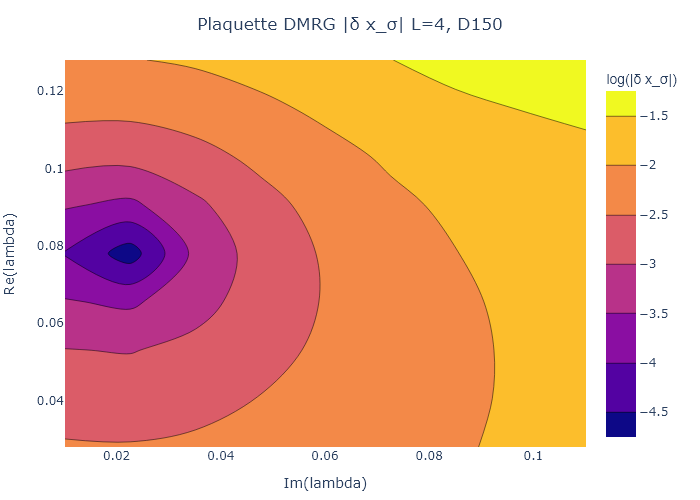

In [19]:
using PlotlyJS
using LaTeXStrings
using JLD2
L = 4
D = 150
Q = 5

Results = load_object("Leading boundary CCFT DMRG $L,D150")

target = 0.134 − 0.021im

z_values = [log(abs((log(Results[1,j]/Results[2,j])  - ((2*pi)/L)*log(1+sqrt(Q))*target))) for j in 1:l]
p = PlotlyJS.plot(PlotlyJS.contour(   z=real(z_values),
    x=real(-im*test_values),
        y=real(test_values),fill=true,colorbar=attr(
            title="log(|δ x_σ|)", # title here
            titleside="top",
            titlefont=attr(
                size=14,
                family="Arial, sans-serif"
            )
        )),Layout(title=attr(text = "Plaquette DMRG |δ x_σ| L=$L, D$D",x = 0.5),xaxis_title="Im(lambda)",yaxis_title="Re(lambda)"))
display(p)

In [36]:
N = 4
distx = 0.5## distance from centre in real

disty = 0.06# distance from centre in imaginary

cent_im =  0.08im

cent_r = 1.1
include("Potts-Operators & Hamiltonian.jl")
## snake like structure of test_values will allow for faster convergence when recycling ψ (because you don't jump the entire distx after the loop)
for i in 1:1:(2*N-1)
    if div(i,2) == 1
        for j in 1:1:(2*N-1)
            if i <N+1
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i])  .+cent_r+ 1im*LinRange(-disty,0.00,N)[j] .+cent_im
                else 
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i])  .+cent_r + 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N] .+cent_im
                end
            else
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N]) .+cent_r  + 1im*LinRange(-disty,0.00,N)[j]  .+cent_im
                else
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N])  .+cent_r+ 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N].+cent_im
                end
            end 
        end
    else
        for j in (2*N-1):-1:1
            if i <N+1
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i]) .+cent_r+ 1im*LinRange(-disty,0.00,N)[j] .+cent_im
                else 
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(-distx,0.00,N)[i])  .+cent_r + 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N] .+cent_im
                end
            else
                if j<N+1
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N]) .+cent_r + 1im*LinRange(-disty,0.00,N)[j] .+cent_im
                else
                    test_values[i+(j-1)*(2*N-1)] =  (LinRange(distx/(N-1),distx+distx/(N-1),N)[i-N])   .+cent_r + 1im*LinRange(disty/(N-1),disty+disty/(N-1),N)[j-N] .+cent_im
                end
            end 
        end
    end
end
for L in [4]
    l = length(test_values)
    Results = zeros(ComplexF64,(2,l))

    ψ = FiniteMPS(L,ℂ^(Q), ℂ^D)
    ψ2 = FiniteMPS(L,ℂ^(Q), ℂ^D)
    #ψ3 = FiniteMPS(L,ℂ^(Q), ℂ^D) if you want this need to change how init works
    for (i,J□) in enumerate(test_values)
        # for (j,JΔ) in enumerate(test_values_1)
        # println(i/l)
        plaq = @mpoham sum(Plaquette_Potts(Q,Potts_βc(Q),J□,JΔ=0){i,i+1} for i in vertices(FiniteChain(L))[1:end-1]) + Plaquette_Potts(Q,Potts_βc(Q),J□,JΔ=0){vertices(FiniteChain(L))[end],vertices(FiniteChain(L))[1]}
        (ψ, envir , delta) = find_groundstate_alt(ψ, plaq, DMRG(maxiter = 500,tol=1e-5, eigalg =MPSKit.Defaults.alg_eigsolve(; ishermitian=false)))
        E = expectation_value(ψ, plaq)
        En, state  = excitations_alt(plaq, FiniteExcited_alt(gsalg = DMRG(eigalg =MPSKit.Defaults.alg_eigsolve(maxiter = 500,tol=1e-5,ishermitian=false))), (ψ,),(1.0,-E),init = ψ2,num=1) 
        ψ2 = state[1]

  
        println(E)
        println(En)
        
        Results[1,i] = E
        Results[2,i] = En[1]
    end

    save_object("Leading boundary plaquette DMRG $L,D$D",Results)
end

┌ Info: DMRG init:	obj = +1.878940385958e+02 +3.983163686117e-01im	err = 1.5577e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.993745567744e+02 +6.491038456370e-01im	err = 2.6180120747e-07	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -199.37455677438768 - 0.6491038456370236im, -131.6167198574076 - 1.0503321762684377im)
199.37455677438768

┌ Info: DMRG init:	obj = -5.206674024371e+02 -1.902572967789e+00im	err = 9.0168e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.316167198574e+02 +1.050332176268e+00im	err = 4.0547191226e-07	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 0.6491038456370236im
ComplexF64[131.6167198574076 + 1.0503321762684377im]
(

┌ Info: DMRG init:	obj = +2.053483135637e+02 +7.894363529420e-01im	err = 1.5605e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.055349224141e+02 +8.402925849683e-01im	err = 6.9600430696e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.412830144128e+02 +1.277407934315e+00im	err = 2.8703e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.418675706103e+02 +1.435862492585e+00im	err = 7.9679001855e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -205.5349224141005 - 0.8402925849682873im, -141.86757061030133 - 1.4358624925852281im)
205.5349224141005 + 0.8402925849682873im
ComplexF64[141.86757061030133 + 1.4358624925852281im]
(1.0, -213.5915186414792 - 1.111064695961146im, -156.022907345948 - 1.9969224130060146im)
213.5915186414792 + 1.111064695961146im
ComplexF64[156.022907345948 + 1.9969224130060146im]


┌ Info: DMRG init:	obj = +2.132682051056e+02 +1.021958994913e+00im	err = 1.8915e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.135915186415e+02 +1.111064695961e+00im	err = 1.6628641140e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.550819327978e+02 +1.746287681226e+00im	err = 3.2322e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.560229073459e+02 +1.996922413006e+00im	err = 1.9130618779e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +2.238167396372e+02 +1.351270474451e+00im	err = 2.3292e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.244171987263e+02 +1.519328217891e+00im	err = 2.3763425748e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.744007507412e+02 +2.428645520170e+00im	err = 3.4646e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.757247931035e+02 +2.768625942152e+00im	err = 8.6484525100e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -224.4171987262979 - 1.5193282178912542im, -175.72479310345787 - 2.7686259421517225im)
224.4171987262979 + 1.5193282178912542im
ComplexF64[175.72479310345787 + 2.7686259421517225im]


┌ Info: DMRG init:	obj = +2.383997029400e+02 +1.847798214902e+00im	err = 2.8978e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.396130863022e+02 +2.191802850855e+00im	err = 6.7174044977e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.012046883931e+02 +3.367186901023e+00im	err = 3.4111e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -239.61308630219554 - 2.1918028508551957im, -202.68013888924582 - 3.729943701322579im)
239.61308630219554 + 2.1918028508551957im
ComplexF64[202.68013888924582 + 3.729943701322579im]


┌ Info: DMRG conv 1:	obj = +2.026801388892e+02 +3.729943701323e+00im	err = 4.8354636728e-08	time = 0.29 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -262.30079729537886 - 3.3639814792878693im, -238.2962568825667 - 4.84376102457727im)
262.30079729537886 + 3.3639814792878693im
ComplexF64[238.2962568825667 + 4.84376102457727im]


┌ Info: DMRG init:	obj = +2.597844306088e+02 +2.665657984585e+00im	err = 3.5897e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.623007972954e+02 +3.363981479288e+00im	err = 4.7368403715e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.370071216351e+02 +4.536336014711e+00im	err = 3.0384e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.382962568826e+02 +4.843761024577e+00im	err = 5.6214325912e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -297.3394610944176 - 5.122803329729421im, -283.8378185842048 - 6.117838869871808im)
297.3394610944176 + 5.122803329729421im
ComplexF64[283.8378185842048 + 6.117838869871808im]


┌ Info: DMRG init:	obj = +2.932597992116e+02 +4.091254871194e+00im	err = 4.0732e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.973394610944e+02 +5.122803329729e+00im	err = 6.4040691867e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.828737932825e+02 +5.890954218600e+00im	err = 2.5095e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.838378185842e+02 +6.117838869872e+00im	err = 5.3029222325e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -199.34533742281636 - 

┌ Info: DMRG init:	obj = +1.466006821778e+02 +3.165193339037e+00im	err = 2.5982e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.993453374228e+02 +1.297491779418e+00im	err = 3.0380531189e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.038200623878e+02 +3.779989508449e+00im	err = 2.0085e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.315597713091e+02 +2.098944096141e+00im	err = 4.2156680797e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.2974917794179652im, -131.55977130905285 - 2.098944096141153im)
199.34533742281636 + 1.2974917794179652im
ComplexF64[131.55977130905285 + 2.098944096141153im]


┌ Info: DMRG init:	obj = +2.053125051107e+02 +1.578002018014e+00im	err = 1.5605e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.054945267951e+02 +1.679470757862e+00im	err = 7.0199745232e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.412128200512e+02 +2.552723702724e+00im	err = 2.8621e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -205.49452679507564 - 1.6794707578618777im, -141.7840640442999 - 2.8691785652814956im)
205.49452679507564 + 1.6794707578618777im
ComplexF64[141.7840640442999 + 2.8691785652814956im]


┌ Info: DMRG conv 1:	obj = +1.417840640443e+02 +2.869178565281e+00im	err = 1.7824565485e-07	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.132184166864e+02 +2.042562648289e+00im	err = 1.8913e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.135328860148e+02 +2.220226887978e+00im	err = 1.6739419654e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.549794228876e+02 +3.489478421272e+00im	err = 3.2127e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -213.53288601482518 - 2.2202268879777995im, -155.9032488239349 - 3.9907241460359373im)
213.53288601482518 + 2.2202268879777995im
ComplexF64[155.9032488239349 + 3.9907241460359373im]


┌ Info: DMRG conv 1:	obj = +1.559032488239e+02 +3.990724146036e+00im	err = 1.8946246363e-07	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -224.325441967946 - 

┌ Info: DMRG init:	obj = +2.237437145965e+02 +2.700227134579e+00im	err = 2.3288e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.243254419679e+02 +3.035017860184e+00im	err = 2.4621833303e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.742565983814e+02 +4.853495687354e+00im	err = 3.4300e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.755674012246e+02 +5.534497174458e+00im	err = 8.8683228329e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


3.035017860183891im, -175.56740122460062 - 5.5344971744575835im)
224.325441967946 + 3.035017860183891im
ComplexF64[175.56740122460062 + 5.5344971744575835im]


┌ Info: DMRG init:	obj = +2.382834961112e+02 +3.691171215148e+00im	err = 2.8971e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.394555292987e+02 +4.376369357213e+00im	err = 7.1423521136e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.010205665025e+02 +6.731023539821e+00im	err = 3.3745e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.024927645421e+02 +7.457763454627e+00im	err = 4.9355780920e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -239.455529298727 - 4.376369357212574im, -202.49276454206844 - 7.45776345462703im)
239.455529298727 + 4.376369357212574im
ComplexF64[202.49276454206844 + 7.45776345462703im]
(1.0, -262.0312198680078 - 6.7184838598341im, -238.08237291567258 - 9.685263408518976im)
262.0312198680078 + 6.7184838598341im
ComplexF64[238.08237291567258 + 9.685263408518976im]


┌ Info: DMRG init:	obj = +2.595824620724e+02 +5.322515168731e+00im	err = 3.5898e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.620312198680e+02 +6.718483859834e+00im	err = 8.8370858927e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.367910358811e+02 +9.070088896095e+00im	err = 2.9991e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.380823729157e+02 +9.685263408519e+00im	err = 5.6912481090e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.929295426444e+02 +8.170981317175e+00im	err = 4.0780e-02
└ @ Main c:\Users\vi

(1.0, -296.9915418154791 - 10.243392641209834im, -283.5915874553556 - 12.232700764826104im)
296.9915418154791 + 10.243392641209834im
ComplexF64[283.5915874553556 + 12.232700764826104im]


┌ Info: DMRG conv 1:	obj = +2.835915874554e+02 +1.223270076483e+01im	err = 5.1518624209e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -199.29669673045288 - 1.9444507614464484im, -131.46500597287607 - 3.1441189738467603im)


┌ Info: DMRG init:	obj = +1.463313139626e+02 +4.745890869565e+00im	err = 2.6020e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.992966967305e+02 +1.944450761446e+00im	err = 3.1348993452e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.036725363130e+02 +5.667561998585e+00im	err = 2.0103e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.314650059729e+02 +3.144118973847e+00im	err = 3.8412235837e-07	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


199.29669673045288 + 1.9444507614464484im
ComplexF64[131.46500597287607 + 3.1441189738467603im]


┌ Info: DMRG init:	obj = +2.052528978449e+02 +2.364829800207e+00im	err = 1.5604e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.054273083308e+02 +2.516425329075e+00im	err = 7.1167036770e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.410960057941e+02 +3.823859360274e+00im	err = 2.8593e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -205.42730833084133 - 2.516425329074864im, -141.6450537693683 - 4.297398966941095im)
205.42730833084133 + 2.516425329074864im
ComplexF64[141.6450537693683 + 4.297398966941095im]


┌ Info: DMRG conv 1:	obj = +1.416450537694e+02 +4.297398966941e+00im	err = 1.7194249779e-07	time = 0.11 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +2.131355700398e+02 +3.060461970128e+00im	err = 1.8910e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.134353893144e+02 +3.325596898450e+00im	err = 1.6923705111e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.548087568693e+02 +5.226471835595e+00im	err = 3.2015e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.557038492675e+02 +5.978268622663e+00im	err = 1.8450066352e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -213.43538931443405 - 3.3255968984497697im, -155.7038492675421 - 5.978268622663105im)
213.43538931443405 + 3.3255968984497697im
ComplexF64[155.7038492675421 + 5.978268622663105im]
(

┌ Info: DMRG init:	obj = +2.236222885383e+02 +4.044571765386e+00im	err = 2.3281e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.241730211853e+02 +4.543459417183e+00im	err = 2.6004415788e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.740163573231e+02 +7.270735815393e+00im	err = 3.4325e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.753049305340e+02 +8.294854603054e+00im	err = 8.9374210259e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -224.17302118529972 - 4.54345941718308im, -175.3049305339779 - 8.294854603054146im)
224.17302118529972 + 4.54345941718308im
ComplexF64[175.3049305339779 + 8.294854603054146im]


┌ Info: DMRG init:	obj = +2.380904515366e+02 +5.525729135869e+00im	err = 2.8958e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.391938231847e+02 +6.546466694925e+00im	err = 7.7972352476e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.007135565637e+02 +1.008815432235e+01im	err = 3.4182e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.021804134043e+02 +1.118134851298e+01im	err = 5.0626064179e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -239.1938231846856 - 6.546466694924943im, -202.1804134043209 - 11.181348512980142im)
239.1938231846856 + 6.546466694924943im
ComplexF64[202.1804134043209 + 11.181348512980142im]
(

┌ Info: DMRG init:	obj = +2.592468237528e+02 +7.961775033432e+00im	err = 3.5900e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.615813921459e+02 +1.005381827324e+01im	err = 1.3251760934e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.364308875199e+02 +1.359869156590e+01im	err = 3.0455e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.377260016538e+02 +1.452225682060e+01im	err = 5.8282235944e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -261.58139214593115 - 10.05381827324416im, -237.72600165384114 - 14.522256820604962im)
261.58139214593115 + 10.05381827324416im
ComplexF64[237.72600165384114 + 14.522256820604962im]
(1.0, -296.4102454165155 - 15.3597012609649im, -283.18137532995615 - 18.34161155163im)
296.4102454165155 + 15.3597012609649im
ComplexF64[283.18137532995615 + 18.34161155163im]


┌ Info: DMRG init:	obj = +2.923780390916e+02 +1.222739579209e+01im	err = 4.0861e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.964102454165e+02 +1.535970126096e+01im	err = 7.0230439438e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.822102765833e+02 +1.766188497881e+01im	err = 2.5092e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.831813753300e+02 +1.834161155163e+01im	err = 5.1197497139e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -199.22872163214439 - 2.589272000787724im, -131.3326476225054 - 4.184147559532012im)
199.22872163214439 + 2.589272000787724im
ComplexF64[131.3326476225054 + 4.184147559532012im]


┌ Info: DMRG init:	obj = +1.459042595837e+02 +6.324471414201e+00im	err = 2.6080e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.992287216321e+02 +2.589272000788e+00im	err = 3.2876630198e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.034563740790e+02 +7.552295189716e+00im	err = 2.0448e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.313326476225e+02 +4.184147559532e+00im	err = 3.4697653385e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.051695981197e+02 +3.149057672075e+00im	err = 1.5603e-02
└ @ Main c:\Users\vi

(1.0, -205.33342743347922 - 3.350057490396489im, -141.4507933263256 - 5.717968909329512im)
205.33342743347922 + 3.350057490396489im
ComplexF64[141.4507933263256 + 5.717968909329512im]


┌ Info: DMRG init:	obj = +2.130198650772e+02 +4.074320596220e+00im	err = 1.8906e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.132993625929e+02 +4.425310553447e+00im	err = 1.7180982754e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -213.29936259290545 - 4.425310553446565im, -155.42475706945953 - 7.956386958766384im)
213.29936259290545 + 4.425310553446565im
ComplexF64[155.42475706945953 + 7.956386958766384im]


┌ Info: DMRG init:	obj = +1.545702133949e+02 +6.954160805482e+00im	err = 3.1978e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.554247570695e+02 +7.956386958766e+00im	err = 1.8655564078e-07	time = 0.33 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.234528819641e+02 +5.382037169291e+00im	err = 2.3271e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.239606934558e+02 +6.041101739740e+00im	err = 2.7856939952e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.736800474349e+02 +9.676511925699e+00im	err = 3.4555e-02
└ @ Main c:\Users\vi

(1.0, -223.96069345577646 - 6.041101739740058im, -174.93714927422286 - 11.046930286542159im)
223.96069345577646 + 6.041101739740058im
ComplexF64

┌ Info: DMRG conv 1:	obj = +1.749371492742e+02 +1.104693028654e+01im	err = 9.0548972220e-08	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


[174.93714927422286 + 11.046930286542159im]
(1.0, -238.82932651016267 - 8.694873732293638im, -201.7429938897904 - 14.898615011733185im)
238.82932651016267 + 8.694873732293638im
ComplexF64[201.7429938897904 + 14.898615011733185im]


┌ Info: DMRG init:	obj = +2.378215158312e+02 +7.347153089952e+00im	err = 2.8941e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.388293265102e+02 +8.694873732294e+00im	err = 8.6314087143e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.002834428962e+02 +1.343521289425e+01im	err = 3.4529e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.017429938898e+02 +1.489861501173e+01im	err = 5.2228654558e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.587790154200e+02 +1.057465527997e+01im	err = 3.5902e-02
└ @ Main c:\Users\vi

(1.0, -260.95052941893954 - 13.359860147378786im, -237.22729778441288 - 19.352507502408333im)
260.95052941893954 + 13.359860147378786im
ComplexF64[237.22729778441288 + 19.352507502408333im]
(1.0, -295.59337157124224 - 20.469974584007865im, -282.60744243132723 - 24.44160270968343im)
295.59337157124224 + 20.469974584007865im
ComplexF64[282.60744243132723 + 24.44160270968343im]


┌ Info: DMRG init:	obj = +2.916036547000e+02 +1.624818484970e+01im	err = 4.0975e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.955933715712e+02 +2.046997458401e+01im	err = 7.5742532606e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.816300707498e+02 +2.353640799646e+01im	err = 2.5410e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.826074424313e+02 +2.444160270968e+01im	err = 5.1398045465e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -199.14153313387263 - 3.2312537627859093im, -131.16301020204764 - 5.21733187194019im)
199.14153313387263 + 3.2312537627859093im
ComplexF64[131.16301020204764 + 5.21733187194019im]


┌ Info: DMRG init:	obj = +1.453149896113e+02 +7.900417512592e+00im	err = 2.6164e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.991415331339e+02 +3.231253762786e+00im	err = 3.4916904805e-07	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.031717283007e+02 +9.433273367826e+00im	err = 2.0718e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.311630102020e+02 +5.217331871940e+00im	err = 3.1939208518e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.050627553149e+02 +3.929832187977e+00im	err = 1.5601e-02
└ @ Main c:\Users\vi

(1.0, -205.21310681563878 - 4.179283847732309im, -141.20164285236373 - 7.12832573639804im)
205.21310681563878 + 4.179283847732309im
ComplexF64[141.20164285236373 + 7.12832573639804im]


┌ Info: DMRG conv 1:	obj = +1.412016428524e+02 +7.128325736398e+00im	err = 1.6702284635e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.128715793581e+02 +5.082820908918e+00im	err = 1.8900e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.131252686132e+02 +5.517541559383e+00im	err = 1.7510538865e-08	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.542641887131e+02 +8.669428643427e+00im	err = 3.2008e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -213.12526861316238 - 5.517541559382768im, -155.06604295624732 - 9.921860728852801im)
213.12526861316238 + 5.517541559382768im
ComplexF64[155.06604295624732 + 9.921860728852801im]


┌ Info: DMRG conv 1:	obj = +1.550660429562e+02 +9.921860728853e+00im	err = 1.9191569230e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -223.68951108305635 - 7.52448172919691im, -174.46372186839014 - 13.787942752294915im)
223.68951108305635 + 7.52448172919691im
ComplexF64[174.46372186839014 + 13.787942752294915im]


┌ Info: DMRG init:	obj = +2.232360775637e+02 +6.710402218570e+00im	err = 2.3257e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.236895110831e+02 +7.524481729197e+00im	err = 3.0127562422e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.732476981706e+02 +1.206690978775e+01im	err = 3.4718e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.744637218684e+02 +1.378794275229e+01im	err = 9.3213645348e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -238.36399048165225 - 10.814398725740748im, -201.18037642864337 - 18.607520453855585im)
238.36399048165225 + 10.814398725740748im
ComplexF64[201.18037642864337 + 18.607520453855585im]


┌ Info: DMRG init:	obj = +2.374780066290e+02 +9.151231276786e+00im	err = 2.8918e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.383639904817e+02 +1.081439872574e+01im	err = 9.6053482075e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.997299121616e+02 +1.676881644456e+01im	err = 3.4803e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.011803764286e+02 +1.860752045386e+01im	err = 5.4202767784e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.581812076706e+02 +1.315240935128e+01im	err = 3.5903e-02
└ @ Main c:\Users\vi

(1.0, -260.13756754011155 - 16.625789226982626im, -236.58648123924635 - 24.17380645717835im)
260.13756754011155 + 16.625789226982626im
ComplexF64[236.58648123924635 + 24.17380645717835im]


┌ Info: DMRG conv 1:	obj = +2.365864812392e+02 +2.417380645718e+01im	err = 6.1899872905e-08	time = 0.31 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -294.5377311239427 - 25.572972712378636im, -281.8701542384864 - 30.52971397077359im)


┌ Info: DMRG init:	obj = +2.906040672877e+02 +2.022018895798e+01im	err = 4.1122e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.945377311239e+02 +2.557297271238e+01im	err = 8.2995642728e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.808846049717e+02 +2.940004397532e+01im	err = 2.5650e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.818701542385e+02 +3.052971397077e+01im	err = 5.1995938386e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


294.5377311239427 + 25.572972712378636im
ComplexF64[281.8701542384864 + 30.52971397077359im]


┌ Info: DMRG init:	obj = +1.445567899851e+02 +9.473383232247e+00im	err = 2.6271e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.990352855894e+02 +3.869703477002e+00im	err = 3.7424618708e-07	time = 0.06 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.028188063355e+02 +1.130958389816e+01im	err = 2.0928e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -199.03528558944106 - 3.86970347700241im, -130.95649845253124 - 6.241989456743399im)
199.03528558944106 + 3.86970347700241im
ComplexF64[130.95649845253124 + 6.241989456743399im]


┌ Info: DMRG conv 1:	obj = +1.309564984525e+02 +6.241989456743e+00im	err = 3.0110188029e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +2.049325599721e+02 +4.706311047739e+00im	err = 1.5600e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.050666296254e+02 +5.003041324987e+00im	err = 5.3943931592e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.404690424339e+02 +7.591471572623e+00im	err = 2.8760e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.408980743498e+02 +8.525897127637e+00im	err = 1.6626232446e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -205.06662962539423 - 5.003041324987086im, -140.89807434981353 - 8.525897127636938im)
205.06662962539423 + 5.003041324987086im
ComplexF64[140.89807434981353 + 8.525897127636938im]
(1.0, -212.91369397832023 - 6.600513422771189im, -154.6278033643495 - 11.871403296428515im)


┌ Info: DMRG init:	obj = +2.126910658688e+02 +6.084670001207e+00im	err = 1.8894e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.129136939783e+02 +6.600513422771e+00im	err = 1.7911432124e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.538912028979e+02 +1.036914690806e+01im	err = 3.2090e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.546278033643e+02 +1.187140329643e+01im	err = 1.9778520173e-07	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


212.91369397832023 + 6.600513422771189im
ComplexF64[154.6278033643495 + 11.871403296428515im]
(1.0, -223.36081328468507 - 8.99025446686202im, -173.88419712537026 - 16.51509199376177

┌ Info: DMRG init:	obj = +2.229726142423e+02 +8.027506352090e+00im	err = 2.3242e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.233608132847e+02 +8.990254466862e+00im	err = 3.2774742267e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.727193504201e+02 +1.443793221320e+01im	err = 3.4834e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.738841971254e+02 +1.651509199376e+01im	err = 9.3958471888e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


im)
223.36081328468507 + 8.99025446686202im
ComplexF64[173.88419712537026 + 16.51509199376177im]


┌ Info: DMRG init:	obj = +2.370616039721e+02 +1.093389562555e+01im	err = 2.8890e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.378004050584e+02 +1.289791177623e+01im	err = 1.0693638471e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.990525412945e+02 +2.008555962145e+01im	err = 3.5023e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -237.800405058438 - 12.897911776228554im, -200.49239234600242 - 22.306079500622094im)
237.800405058438 + 12.897911776228554im
ComplexF64[200.49239234600242 + 22.306079500622094im]


┌ Info: DMRG conv 1:	obj = +2.004923923460e+02 +2.230607950062e+01im	err = 5.6573999777e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.574563102614e+02 +1.568636590529e+01im	err = 3.5902e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.591412184036e+02 +1.983977420223e+01im	err = 2.8616605951e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.344859714401e+02 +2.712852522407e+01im	err = 3.1330e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -259.1412184036247 - 19.839774202233365im, -235.8038406683354 - 28.983977493515074im)
259.1412184036247 + 19.839774202233365im
ComplexF64[235.8038406683354 + 28.983977493515074im]


┌ Info: DMRG conv 1:	obj = +2.358038406683e+02 +2.898397749352e+01im	err = 6.4200661311e-08	time = 0.08 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0,

┌ Info: DMRG init:	obj = +2.893762461920e+02 +2.412901894616e+01im	err = 4.1303e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.932390367676e+02 +3.066823860999e+01im	err = 9.2162811557e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.799742710373e+02 +3.525014624398e+01im	err = 2.5830e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.809699826243e+02 +3.660299575713e+01im	err = 5.2894447716e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 -293.23903676757493 - 30.66823860998986im, -280.96998262429776 - 36.60299575713435im)
293.23903676757493 + 30.66823860998986im
ComplexF64[280.96998262429776 + 36.60299575713435im]
(

┌ Info: DMRG init:	obj = +1.436203521283e+02 +1.104328014602e+01im	err = 2.6404e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.989101658037e+02 +4.503939864125e+00im	err = 4.0364857437e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.023978726089e+02 +1.318031796577e+01im	err = 2.1093e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.307136085985e+02 +7.256457958283e+00im	err = 2.9039523814e-07	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -198.91016580368944 - 4.50393986412525im, -130.71360859852743 - 7.25645795828277im)
198.91016580368944 + 4.50393986412525im
ComplexF64[130.71360859852743 + 7.25645795828277im]


┌ Info: DMRG init:	obj = +2.047792426832e+02 +5.477665683394e+00im	err = 1.5597e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.048943372602e+02 +5.820291538173e+00im	err = 5.5013439594e-09	time = 0.08 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -204.89433726019695 - 5.820291538173456im, -140.5406785491578 - 9.908100074764883im)
204.89433726019695 + 5.820291538173456im
ComplexF64

┌ Info: DMRG init:	obj = +1.401694874324e+02 +8.825262312599e+00im	err = 2.8864e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.405406785492e+02 +9.908100074765e+00im	err = 1.6672428756e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


[140.5406785491578 + 9.908100074764883im]


┌ Info: DMRG init:	obj = +2.124787499143e+02 +7.078604996471e+00im	err = 1.8886e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.126653429351e+02 +7.672510751246e+00im	err = 1.8382611125e-08	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.534519080112e+02 +1.205017415962e+01im	err = 3.2208e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.541101653246e+02 +1.380163943913e+01im	err = 4.7514723831e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -212.66534293508636 - 7.672510751246101im, -154.11016532460127 - 13.80163943913458im)
212.66534293508636 + 7.672510751246101im
ComplexF64[154.11016532460127 + 13.80163943913458im]
(1.0, 

┌ Info: DMRG init:	obj = +2.226633795023e+02 +9.331263319550e+00im	err = 2.3223e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.229762145696e+02 +1.043522364965e+01im	err = 3.5769100815e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.720950597450e+02 +1.678547427609e+01im	err = 3.4921e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.731979920094e+02 +1.922555401794e+01im	err = 1.5252789532e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


-222.97621456962395 - 10.435223649649858im, -173.197992009437 - 19.225554017944987im)
222.97621456962395 + 10.435223649649858im
ComplexF64[173.197992009437 + 19.225554017944987im]
(1.0, -237.1418528004737 - 14.938397626416945im, -199.6788327850515 - 25.992381577317378im)
237.1418528004737 + 14.938397626416945im
ComplexF64[199.6788327850515 + 25.992381577317378im]


┌ Info: DMRG init:	obj = +2.365743379245e+02 +1.269125881087e+01im	err = 2.8856e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.371418528005e+02 +1.493839762642e+01im	err = 1.1881886169e-07	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.982507808981e+02 +2.338200790094e+01im	err = 3.5211e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.996788327851e+02 +2.599238157732e+01im	err = 5.9346847390e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +2.566080550083e+02 +1.816799302648e+01im	err = 3.5895e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.579600794008e+02 +2.298857552620e+01im	err = 3.4802445939e-08	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.335494639129e+02 +3.161178454664e+01im	err = 3.1513e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.348797380502e+02 +3.378088503707e+01im	err = 6.6891443973e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -257.9600794008099 - 22.98857552619786im, -234.87973805015702 - 33.780885037071855im)
257.9600794008099 + 22.98857552619786im
ComplexF64[234.87973805015702 + 33.780885037071855im]
(

┌ Info: DMRG init:	obj = +2.879164556370e+02 +2.795857295364e+01im	err = 4.1518e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.916917661066e+02 +3.575647201796e+01im	err = 1.0349425134e-07	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +2.788995556594e+02 +4.108411752922e+01im	err = 2.5966e-02
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +2.799075072762e+02 +4.265851134916e+01im	err = 5.3937204239e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -291.6917661065655 - 35.75647201796463im, -279.907507276244 - 42.65851134916041im)
291.6917661065655 + 35.75647201796463im
ComplexF64[279.907507276244 + 42.65851134916041im]
(1.0, -187.4210333327814 - 

┌ Info: DMRG init:	obj = +1.126439226137e+02 +2.686093812376e+00im	err = 3.8866e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874210333328e+02 +9.747634779094e-01im	err = 4.3280223909e-08	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +6.629822110717e+01 +3.204588062339e+00im	err = 3.7657e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.133506662764e+02 +1.404244780438e+00im	err = 5.6070781481e-07	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


0.9747634779094321im, -113.35066627638089 - 1.4042447804380593im)
187.4210333327814 + 0.9747634779094321im
ComplexF64[113.35066627638089 + 1.4042447804380593im]


┌ Info: DMRG init:	obj = +1.874599485305e+02 +9.776294886793e-01im	err = 1.1862e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874599255695e+02 +9.780177329100e-01im	err = 3.3531961889e-10	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.134067275308e+02 +1.408373557065e+00im	err = 2.5511e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -187.45992556949676 - 0.9780177329100057im, -113.4066585744847 - 1.4094615167178606im)
187.45992556949676 + 0.9780177329100057im
ComplexF64[113.4066585744847 + 1.4094615167178606im]


┌ Info: DMRG conv 1:	obj = +1.134066585745e+02 +1.409461516718e+00im	err = 2.0543195123e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -187.49894756097112 - 0.9812840893015279im, -113.46285862480552 - 1.4147013158744766im)


┌ Info: DMRG init:	obj = +1.874989706859e+02 +9.808933118778e-01im	err = 1.1896e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874989475610e+02 +9.812840893015e-01im	err = 3.3998938914e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.134629280952e+02 +1.413605631653e+00im	err = 2.5579e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.134628586248e+02 +1.414701315874e+00im	err = 2.0704001951e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


187.49894756097112 + 0.9812840893015279im
ComplexF64[113.46285862480552 + 1.4147013158744766im]
(

┌ Info: DMRG init:	obj = +1.875381230792e+02 +9.841692720479e-01im	err = 1.1931e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875380997937e+02 +9.845626095956e-01im	err = 3.4447681169e-10	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135193373324e+02 +1.418860836927e+00im	err = 2.5644e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.135192673308e+02 +1.419964253130e+00im	err = 2.0799491960e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.5380997937224 - 0.9845626095956138im, -113.51926733081977 - 1.4199642531298615im)
187.5380997937224 + 0.9845626095956138im
ComplexF64[113.51926733081977 + 1.4199642531298615im]
(1.0, 

┌ Info: DMRG init:	obj = +1.875774061994e+02 +9.874574318850e-01im	err = 1.1966e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875773827521e+02 +9.878533474051e-01im	err = 3.4902405675e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135759561492e+02 +1.424139248331e+00im	err = 2.5709e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.135758856118e+02 +1.425250455983e+00im	err = 2.0895992939e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


-187.57738275214615 - 0.9878533474050922im, -113.5758856117847 - 1.4252504559833876im)
187.57738275214615 + 0.9878533474050922im
ComplexF64[113.5758856117847 + 1.4252504559833876im]
(

┌ Info: DMRG init:	obj = +1.872631249439e+02 +1.003383367497e+00im	err = 9.5663e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.872634883462e+02 +1.000174760214e+00im	err = 2.5466674250e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.131224821935e+02 +1.447656786108e+00im	err = 2.0600e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.131235399572e+02 +1.438662463197e+00im	err = 1.6482278758e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.263488346197 - 1.0001747602141822im, -113.12353995721877 - 1.4386624631968452im)
187.263488346197 + 1.0001747602141822im
ComplexF64[113.12353995721877 + 1.4386624631968452im]
(1.0, -187.30185421346738 - 1.0035086792971128im, -113.17868744650022 - 1.4439920806719422im)
187.30185421346738

┌ Info: DMRG init:	obj = +1.873018789836e+02 +1.003115485528e+00im	err = 1.1724e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873018542135e+02 +1.003508679297e+00im	err = 3.1861703596e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.131787614757e+02 +1.442892435090e+00im	err = 2.5256e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.131786874465e+02 +1.443992080672e+00im	err = 2.0276794235e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 1.0035086792971128im
ComplexF64[113.17868744650022 + 1.4439920806719422im]
(1.0, -187.3403478784542 - 1.0068549714251553im, -113.23403894470353 - 1.4493451031139741im)


┌ Info: DMRG init:	obj = +1.873403728198e+02 +1.006459207038e+00im	err = 1.1758e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873403478785e+02 +1.006854971425e+00im	err = 3.2272043524e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.132341135367e+02 +1.448237722767e+00im	err = 2.5321e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.132340389447e+02 +1.449345103114e+00im	err = 2.0369649010e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


187.3403478784542 + 1.0068549714251553im
ComplexF64[113.23403894470353 + 1.4493451031139741im]
(

┌ Info: DMRG init:	obj = +1.873789949286e+02 +1.009815337973e+00im	err = 1.1793e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873789698149e+02 +1.010213690715e+00im	err = 3.2697746051e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.132896705049e+02 +1.453606484227e+00im	err = 2.5385e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.132895953453e+02 +1.454721658825e+00im	err = 2.0461514538e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.3789698148583 - 1.0102136907147168im, -113.2895953453149 - 1.4547216588253515im)
187.3789698148583 + 1.0102136907147168im
ComplexF64[113.2895953453149 + 1.4547216588253515im]
(1.0, -187.41772049837869 - 1.0135848916991452im, -113.34535754686992 - 1.4601218767540975im)
187.41772049837869

┌ Info: DMRG init:	obj = +1.874177457859e+02 +1.013183932607e+00im	err = 1.1827e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874177204984e+02 +1.013584891699e+00im	err = 3.3129130166e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.133454332788e+02 +1.458998848150e+00im	err = 2.5450e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.133453575469e+02 +1.460121876754e+00im	err = 2.0554300034e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 1.0135848916991452im
ComplexF64[113.34535754686992 + 1.4601218767540975im]
(

┌ Info: DMRG init:	obj = +1.874566258694e+02 +1.016565045636e+00im	err = 1.1861e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874566004068e+02 +1.016968629209e+00im	err = 3.3566274754e-10	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.134014027620e+02 +1.464414943861e+00im	err = 2.5515e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.134013264528e+02 +1.465545886733e+00im	err = 2.0648024949e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.45660040679718 - 1.016968629209399im, -113.40132645281147 - 1.465545886732667im)
187.45660040679718 + 1.016968629209399im
ComplexF64[113.40132645281147 + 1.465545886732667im]


┌ Info: DMRG init:	obj = +1.874956356589e+02 +1.019958732050e+00im	err = 1.1896e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874956100200e+02 +1.020364958376e+00im	err = 3.4009252456e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.134575798627e+02 +1.469854901576e+00im	err = 2.5580e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -187.4956100199887 - 1.020364958375869im, -113.4575029715214 - 1.4709938194853829im)


┌ Info: DMRG conv 1:	obj = +1.134575029715e+02 +1.470993819485e+00im	err = 2.0742708146e-09	time = 0.28 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


187.4956100199887 + 1.020364958375869im
ComplexF64[113.4575029715214 + 1.4709938194853829im]


┌ Info: DMRG init:	obj = +1.875347756366e+02 +1.023365047142e+00im	err = 1.1931e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875347498199e+02 +1.023773934631e+00im	err = 3.4458146317e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135139654945e+02 +1.475318852403e+00im	err = 2.5645e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -187.5347498199328 - 1.0237739346306574im, -113.51388801635542 - 1.4764658066356526im)
187.5347498199328 + 1.0237739346306574im
ComplexF64[113.51388801635542 + 1.4764658066356526im]


┌ Info: DMRG conv 1:	obj = +1.135138880164e+02 +1.476465806636e+00im	err = 2.0838371455e-09	time = 0.07 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +1.875740462864e+02 +1.026784046508e+00im	err = 1.1966e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875740202907e+02 +1.027195613710e+00im	err = 3.4913033992e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135705605757e+02 +1.480806928353e+00im	err = 2.5710e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.135704825057e+02 +1.481961980714e+00im	err = 2.0935033231e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.5740202907244 - 1.0271956137095264im, -113.57048250567603 - 1.4819619807135136im)
187.5740202907244 + 1.0271956137095264im
ComplexF64[113.57048250567603 + 1.4819619807135136im]
(

┌ Info: DMRG init:	obj = +1.872597284423e+02 +1.041802465433e+00im	err = 9.5663e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.872600969415e+02 +1.038470647993e+00im	err = 2.5475121478e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.131170454349e+02 +1.503035667773e+00im	err = 2.0601e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.131181204617e+02 +1.493696458294e+00im	err = 1.6514952981e-08	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.26009694146995 - 1.0384706479930141im, -113.1181204616851 - 1.4936964582937016im)
187.26009694146995 + 1.0384706479930141im
ComplexF64[113.1181204616851 + 1.4936964582937016im]


┌ Info: DMRG init:	obj = +1.872984775211e+02 +1.041523971316e+00im	err = 1.1724e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.872984502271e+02 +1.041932101420e+00im	err = 3.1871646240e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.131733256194e+02 +1.498088241771e+00im	err = 2.5257e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -187.2984502271097 - 1.0419321014196794im, -113.17324416523117 - 1.4992295748970004im)
187.2984502271097 + 1.0419321014196794im
ComplexF64[113.17324416523117 + 1.4992295748970004im]


┌ Info: DMRG conv 1:	obj = +1.131732441652e+02 +1.499229574897e+00im	err = 2.0316247442e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -187.33693125533827

┌ Info: DMRG init:	obj = +1.873369587378e+02 +1.044995602148e+00im	err = 1.1758e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873369312553e+02 +1.045406400343e+00im	err = 3.2282160793e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.132286538200e+02 +1.503637626907e+00im	err = 2.5322e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.132285717477e+02 +1.504786987262e+00im	err = 2.0409232512e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 - 1.04540640034341im, -113.22857174766251 - 1.504786987261607im)
187.33693125533827 + 1.04540640034341im
ComplexF64[113.22857174766251 + 1.504786987261607im]


┌ Info: DMRG init:	obj = +1.873755681717e+02 +1.048480116245e+00im	err = 1.1793e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873755404996e+02 +1.048893600941e+00im	err = 3.2708010075e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.132841867975e+02 +1.509211379239e+00im	err = 2.5386e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -187.375540499564 - 1.0488936009411478im, -113.28410410155851 - 1.510368828545729im)
187.375540499564 + 1.0488936009411478im
ComplexF64[113.28410410155851 + 1.510368828545729im]


┌ Info: DMRG conv 1:	obj = +1.132841041016e+02 +1.510368828546e+00im	err = 2.0501260493e-09	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(

┌ Info: DMRG init:	obj = +1.874143062986e+02 +1.051977569950e+00im	err = 1.1827e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874142784352e+02 +1.052393759822e+00im	err = 3.3139545314e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.133399254493e+02 +1.514809632317e+00im	err = 2.5451e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.133398421246e+02 +1.515975232583e+00im	err = 2.0594206979e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.41427843518395 - 1.0523937598217705im, -113.33984212455789 - 1.5159752325831526im)
187.41427843518395 + 1.0523937598217705im
ComplexF64[113.33984212455789 + 1.5159752325831526im]
(1.0, -187.4531455396751 - 1.0559069339027543im, -113.39578671919767 - 1.5216063341254527im)
187.4531455396751 + 1.0559069339027543im
ComplexF64[113.39578671919767 + 1.5216063341254527im]


┌ Info: DMRG init:	obj = +1.874531735957e+02 +1.055488020038e+00im	err = 1.1861e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874531455397e+02 +1.055906933903e+00im	err = 3.3576847134e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.133958706780e+02 +1.520432520368e+00im	err = 2.5515e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.133957867192e+02 +1.521606334125e+00im	err = 2.0688095509e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.874921705427e+02 +1.059011523594e+00im	err = 1.1896e-04
└ @ Main c:\Users\vi

(1.0, -187.4921422926064 - 1.0594331804125765im, -113.45193879294807 - 1.527262268849718im)
187.4921422926064 + 1.0594331804125765im
ComplexF64[113.45193879294807 + 1.527262268849718im

┌ Info: DMRG conv 1:	obj = +1.874921422926e+02 +1.059433180413e+00im	err = 3.4019984475e-10	time = 0.30 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.134520233911e+02 +1.526080178540e+00im	err = 2.5580e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.134519387929e+02 +1.527262268850e+00im	err = 2.0782943331e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


]


┌ Info: DMRG init:	obj = +1.875312976213e+02 +1.062548138014e+00im	err = 1.1931e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875312691756e+02 +1.062972556893e+00im	err = 3.4469042358e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135083845011e+02 +1.531752742908e+00im	err = 2.5646e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62


(1.0, -187.53126917564913 - 1.062972556892617im, -113.50829925824432 - 1.5329431733661258im)
187.53126917564913 + 

┌ Info: DMRG conv 1:	obj = +1.135082992582e+02 +1.532943173366e+00im	err = 2.0878772421e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.062972556892617im
ComplexF64[113.50829925824432 + 1.5329431733661258im]
(

┌ Info: DMRG init:	obj = +1.875705553153e+02 +1.066097921009e+00im	err = 1.1966e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875705266726e+02 +1.066525121200e+00im	err = 3.4924094807e-10	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135649549256e+02 +1.537450350486e+00im	err = 2.5711e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.135648690325e+02 +1.538649185226e+00im	err = 2.0975599650e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.57052667258785 - 1.0665251211996478im, -113.56486903252193 - 1.5386491852256032im)
187.57052667258785 + 1.0665251211996478im
ComplexF64[113.56486903252193 + 1.5386491852256032im]
(

┌ Info: DMRG init:	obj = +1.872562038935e+02 +1.080208721228e+00im	err = 9.5663e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.872565782657e+02 +1.076753746448e+00im	err = 2.5483897483e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.131114034007e+02 +1.558390173616e+00im	err = 2.0602e-03
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.131124979762e+02 +1.548706289564e+00im	err = 1.6548863665e-08	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.25657826568653 - 1.076753746447816im, -113.1124979762013 - 1.5487062895637804im)
187.25657826568653 + 1.076753746447816im
ComplexF64[113.1124979762013 + 1.5487062895637804im]
(1.0, -187.29491849842623 - 1.0803426782211507im, -113.16759700607584 - 1.5544427732758535im)
187.29491849842623 + 1.0803426782211507im
ComplexF64[113.16759700607584 + 1.5544427732758535im]


┌ Info: DMRG init:	obj = +1.872949484101e+02 +1.079919630176e+00im	err = 1.1724e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.872949184984e+02 +1.080342678221e+00im	err = 3.1881981086e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.131676861603e+02 +1.553259813578e+00im	err = 2.5258e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.131675970061e+02 +1.554442773276e+00im	err = 2.0357191933e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -187.33338641657068 - 1.083944927638638im, -113.22289977996775 - 1.5602044426412112im)
187.33338641657068 + 1.083944927638638im


┌ Info: DMRG init:	obj = +1.873334165345e+02 +1.083519114168e+00im	err = 1.1758e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873333864166e+02 +1.083944927639e+00im	err = 3.2292677616e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.132229896099e+02 +1.559013163766e+00im	err = 2.5322e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.132228997800e+02 +1.560204442641e+00im	err = 2.0450309980e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


ComplexF64[113.22289977996775 + 1.5602044426412112im]
(1.0, -187.37198249322302 - 1.0875605529362251im, -113.27840718951542 - 1.5659914356657372im)
187.37198249322302 + 1.0875605529362251im
ComplexF64[113.27840718951542 + 1.5659914356657372im]


┌ Info: DMRG init:	obj = +1.873720128189e+02 +1.087131954961e+00im	err = 1.1793e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.873719824932e+02 +1.087560552936e+00im	err = 3.2718681428e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.132784977010e+02 +1.564791773658e+00im	err = 2.5387e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.132784071895e+02 +1.565991435666e+00im	err = 2.0542503240e-09	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


(1.0, -187.41070720346676 - 1.0911896127958696im, -113.33412013142707 - 1.5718038910615226im)
187.41070720346676

┌ Info: DMRG init:	obj = +1.874107377385e+02 +1.090758210961e+00im	err = 1.1827e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874107072035e+02 +1.091189612796e+00im	err = 3.3150374994e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.133342113302e+02 +1.570595781665e+00im	err = 2.5452e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.133341201314e+02 +1.571803891062e+00im	err = 2.0635619075e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 + 1.0911896127958696im
ComplexF64[113.33412013142707 + 1.5718038910615226im]
(1.0, -187.44956102446406

┌ Info: DMRG init:	obj = +1.874495917703e+02 +1.094397941024e+00im	err = 1.1861e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874495610245e+02 +1.094832166220e+00im	err = 3.3587836288e-10	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.133901313991e+02 +1.576425326909e+00im	err = 2.5516e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.133900395073e+02 +1.577641948492e+00im	err = 2.0729677578e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


 - 1.0948321662195455im, -113.39003950730138 - 1.5776419484917186im)
187.44956102446406 + 1.0948321662195455im
ComplexF64[113.39003950730138 + 1.5776419484917186im]
(

┌ Info: DMRG init:	obj = +1.874885753938e+02 +1.098051204325e+00im	err = 1.1896e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.874885444355e+02 +1.098488272532e+00im	err = 3.4031138492e-10	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.134462588143e+02 +1.582280549463e+00im	err = 2.5581e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.134461662237e+02 +1.583505748579e+00im	err = 2.0824698954e-09	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


1.0, -187.48854443546574 - 1.0984882725315857im, -113.44616622366215 - 1.583505748578642im)
187.48854443546574 + 1.0984882725315857im
ComplexF64[113.44616622366215 + 1.583505748578642im]
(1.0, -187.52765791782352 - 1.1021579913805744im, -113.5025011919907 - 1.5893954329115312im)
187.52765791782352 + 1.1021579913805744im
ComplexF64[113.5025011919907 + 1.5893954329115312im]


┌ Info: DMRG init:	obj = +1.875276890902e+02 +1.101718060363e+00im	err = 1.1931e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.875276579178e+02 +1.102157991381e+00im	err = 3.4480364172e-10	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.135025944873e+02 +1.588161590362e+00im	err = 2.5646e-04
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:62
┌ Info: DMRG conv 1:	obj = +1.135025011920e+02 +1.589395432912e+00im	err = 2.0920697181e-09	time = 0.04 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77
┌ Info: DMRG init:	obj = +1.875669333431e+02 +1.105398568962e+00im	err = 1.1966e-04
└ @ Main c:\Users\vi

(1.0, -187.56690195500005 - 1.1058413827419855im, -113.55904532876241 - 1.595311143957584im)
187.56690195500005 + 1.1058413827419855im
ComplexF64[113.55904532876241 + 1.595311143957584im]


┌ Info: DMRG conv 1:	obj = +1.135590453288e+02 +1.595311143958e+00im	err = 4.9023177914e-10	time = 0.30 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:77


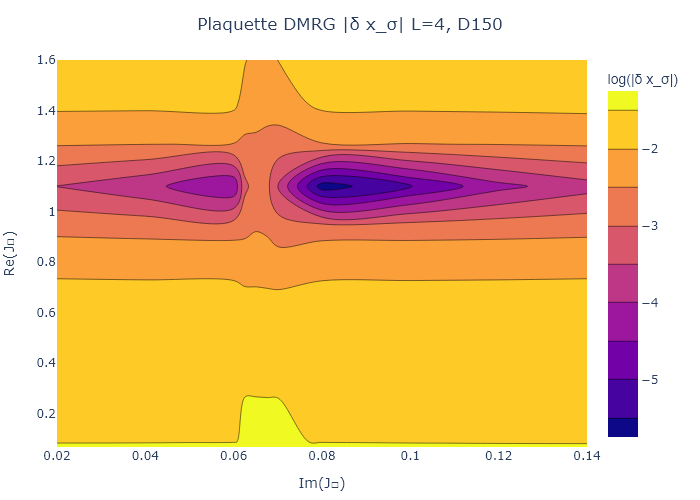

In [37]:
using PlotlyJS
using LaTeXStrings
using JLD2
L = 4
D = 150
Q = 5

Results = load_object("Leading boundary plaquette DMRG $L,D150")

target = 0.134 − 0.021im

z_values = [log(abs((log(Results[1,j]/Results[2,j])  - ((2*pi)/L)*log(1+sqrt(Q))*target))) for j in 1:l]
p = PlotlyJS.plot(PlotlyJS.contour(   z=real(z_values),
    x=real(-im*test_values),
        y=real(test_values),fill=true,colorbar=attr(
            title="log(|δ x_σ|)", # title here
            titleside="top",
            titlefont=attr(
                size=14,
                family="Arial, sans-serif"
            )
        )),Layout(title=attr(text = "Plaquette DMRG |δ x_σ| L=$L, D$D",x = 0.5),xaxis_title="Im(J□)",yaxis_title="Re(J□)"))
display(p)
